# Abstract
The intention of this Jupyter Notebook is to provide an environment that can be used for retrosynthesis. It is dependent on pandas, rdkit, IPython.display

# SCScore computation capability
The goal of this module is to compute SCScores!

In [23]:
'''
This is a standalone, importable SCScorer model. It does not have tensorflow as a
dependency and is a more attractive option for deployment. The calculations are
fast enough that there is no real reason to use GPUs (via tf) instead of CPUs (via np)
'''

import math, sys, random, os
import numpy as np
import time
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import json
import gzip
import six

import os
project_root = '/home/karthiksankar2/Documents/Dropbox (MIT)/MIT/Research_Jensen_Lab/RDChiral'

score_scale = 5.0
min_separation = 0.25

FP_len = 1024
FP_rad = 2

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

class SCScorer():
    def __init__(self, score_scale=score_scale):
        self.vars = []
        self.score_scale = score_scale
        self._restored = False

    def restore(self, weight_path=os.path.join(project_root, 'model.ckpt-10654.as_numpy.json.gz'), FP_rad=FP_rad, FP_len=FP_len):
        self.FP_len = FP_len; self.FP_rad = FP_rad
        self._load_vars(weight_path)
        #print('Restored variables from {}'.format(weight_path))

        if 'uint8' in weight_path or 'counts' in weight_path:
            def mol_to_fp(self, mol):
                if mol is None:
                    return np.array((self.FP_len,), dtype=np.uint8)
                fp = AllChem.GetMorganFingerprint(mol, self.FP_rad, useChirality=True) # uitnsparsevect
                fp_folded = np.zeros((self.FP_len,), dtype=np.uint8)
                for k, v in six.iteritems(fp.GetNonzeroElements()):
                    fp_folded[k % self.FP_len] += v
                return np.array(fp_folded)
        else:
            def mol_to_fp(self, mol):
                if mol is None:
                    return np.zeros((self.FP_len,), dtype=np.float32)
                return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, self.FP_rad, nBits=self.FP_len,
                    useChirality=True), dtype=np.bool)
        self.mol_to_fp = mol_to_fp

        self._restored = True
        return self

    def smi_to_fp(self, smi):
        if not smi:
            return np.zeros((self.FP_len,), dtype=np.float32)
        return self.mol_to_fp(self, Chem.MolFromSmiles(smi))

    def apply(self, x):
        if not self._restored:
            raise ValueError('Must restore model weights!')
        # Each pair of vars is a weight and bias term
        for i in range(0, len(self.vars), 2):
            last_layer = (i == len(self.vars)-2)
            W = self.vars[i]
            b = self.vars[i+1]
            x = np.matmul(x, W) + b
            if not last_layer:
                x = x * (x > 0) # ReLU
        x = 1 + (score_scale - 1) * sigmoid(x)
        return x

    def get_score_from_smi(self, smi='', v=False):
        if not smi:
            return ('', 0.)
        fp = np.array((self.smi_to_fp(smi)), dtype=np.float32)
        if sum(fp) == 0:
            if v: print('Could not get fingerprint?')
            cur_score = 0.
        else:
            # Run
            cur_score = self.apply(fp)
            if v: print('Score: {}'.format(cur_score))
        mol = Chem.MolFromSmiles(smi)
        if mol:
            smi = Chem.MolToSmiles(mol, isomericSmiles=True, kekuleSmiles=True)
        else:
            smi = ''
        return (smi, cur_score)

    def _load_vars(self, weight_path):
        if weight_path.endswith('pickle'):
            import cPickle as pickle
            with open(weight_path, 'rb') as fid:
                self.vars = pickle.load(fid)
                self.vars = [x.tolist() for x in self.vars]
        elif weight_path.endswith('json.gz'):
            with gzip.GzipFile(weight_path, 'r') as fin:    # 4. gzip
                json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)
                json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
                self.vars = json.loads(json_str)
                self.vars = [np.array(x) for x in self.vars]

# Add drawing capability

In [24]:
#import rdkit modules
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

#load the IPython.display module
from IPython.display import SVG

#draw a reaction taking rdkit reaction as input
def draw_rxn(rxn, unmap=True, width=800, height=200):
    if unmap:
        for mol in rxn.GetReactants():
            [a.SetAtomMapNum(0) for a in mol.GetAtoms()]
        for mol in rxn.GetProducts():
            [a.SetAtomMapNum(0) for a in mol.GetAtoms()]
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    drawer.DrawReaction(rxn)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:', '')
    display(SVG(svg))

#draw a reaction taking SMILES as input
def draw_rxn_smi(rxn_smi, unmap=True, width=800, height=200):
    rxn = AllChem.ReactionFromSmarts(rxn_smi, useSmiles=True)
    draw_rxn(rxn, unmap=unmap, width=width, height=height)

# draw a molecule taking RDKit mol as input
def draw_mol(mol, unmap=True, width=800, height=200):
    if unmap:
        [a.SetAtomMapNum(0) for a in mol.GetAtoms()]
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    
    Chem.rdDepictor.Compute2DCoords(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:', '')
    display(SVG(svg))

# draw a molecule taking SMILES as input
def draw_smi(smi, unmap=True, width=800, height=200):
    mol = Chem.MolFromSmiles(smi)
    draw_mol(mol, unmap=unmap, width=width, height=height)

# general draw code
def draw(inp, unmap=True, width=800, height=200):
    if isinstance(inp, str):
        if '>' in inp:
            draw_rxn_smi(inp, unmap=unmap, width=width, height=height)
        else:
            draw_smi(inp, unmap=unmap, width=width, height=height)
    elif isinstance(inp, Chem.rdChemReactions.ChemicalReaction):
        draw_rxn(inp, unmap=unmap, width=width, height=height)
    else:
        draw_mol(inp, unmap=unmap, width=width, height=height)

# draw molecule with stereochemistry
def mol_with_stereo(mol,molSize=(300,300), kekulize=False, fontSize = 0.8, LineWidth = 1):
    # check for defective molecule
    if mol is None:
        return None

    mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.SetFontSize(fontSize)
    drawer.drawOptions().addStereoAnnotation = True
    # drawer.drawOptions().addAtomIndices = True

    try:
        drawer.SetLineWidth(LineWidth)
    except:
        pass

    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

# Load the dataset

In [25]:
#import pandas
import pandas as pd

#load the dataset
processed_data = pd.read_pickle('RHEA_atom_mapped_timepoint_7_success.pkl')

#if there are multiple atom mapped solutions, then ennumerate
_id = []
prod_smiles = []
rxn_smiles = []
atom_map_smiles = []
not_atom_map_smiles = []
dataset = []

for row in processed_data.itertuples():
    for list_item in row[3]:
        _id.append (row [1])
        prod_smiles.append (row[2])
        rxn_smiles.append (list_item)
        atom_map_smiles.append (row[4])
        not_atom_map_smiles.append (row[5]) 

#save the new dataset as processed_data, to replace the old one
processed_data = pd.DataFrame({'id': _id,
                        'prod_smiles': prod_smiles,
                        'rxn_smiles': rxn_smiles,
                        'atom mapped smiles-input': atom_map_smiles,
                        'not atom mapped smiles-input':not_atom_map_smiles})

# Add fingerprint information to the pandas dataframe

In [26]:
# import the necessary RDKit modules
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs

# Set up the fingerprint of molecules
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi),2,useChirality=True, useFeatures=True)

# Set up the similarity label
similarity_metric = DataStructs.BulkDiceSimilarity

# Gets Morgan Fingerprints for all products
all_fps = []

for smi in processed_data['prod_smiles']:
    all_fps.append(getfp(smi))
    
#Append the fingerprints of all products
processed_data['prod_fp'] = all_fps

# Code for retrosynthesis

In [27]:
# SETUP THE TRAINING DATASET

# call the knowledge base 'datasub' because this is a legacy code and datasub is the original name
datasub = processed_data

In [28]:
# import all desired modules
import sys 
import os
import re
import copy
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem.rdchem import ChiralType, BondType, BondDir
from rdchiral.utils import vprint, PLEVEL, atoms_are_different
from rdchiral.initialization import rdchiralReaction, rdchiralReactants
from rdchiral.chiral import template_atom_could_have_been_tetra, copy_chirality,\
    atom_chirality_matches
from rdchiral.clean import canonicalize_outcome_smiles, combine_enantiomers_into_racemic
from rdchiral.bonds import BondDirOpposite, restore_bond_stereo_to_sp2_atom
import numpy as np

# load the template extraction and application changes
from template_extractor_enz_v4 import extract_from_reaction
from main_v3 import rdchiralRun

In [29]:
#jx_cache stores information about 
jx_cache = {} 
draw = False              
debug = False
rank_print = False

def do_one(ix, draw=draw, debug=debug, max_prec=50):
    
    #get product smiles
    product_smiles = []
    product_smiles.append (datasub_test ['prod_smiles'][ix])
    
    # for the moment, it is just an empty string
    rec_for_printing = '' 
    
    #loads product SMILES into RDKit object
    ex = Chem.MolFromSmiles(datasub_test ['prod_smiles'][ix]) 
    
    #loads product SMILES into RDChiral object
    rct = rdchiralReactants(datasub_test ['prod_smiles'][ix])
    
    #if Draw = True, then Print Mol {Index}
    if draw:
        print (product_smiles)
        print ('The desired molecule is:')
        m = Chem.MolFromSmiles (product_smiles[0])
        display (SVG (mol_with_stereo(m)))
        
    #if Debug = True, then Print {Product SMILES} + go to new line +
    # True reaction: {reaction smiles}
    if debug:
        rec_for_printing += 'Desired Product:' + '\n'
        rec_for_printing += datasub_test ['prod_smiles'][ix] + '\n'
        rec_for_printing += 'True reaction:' + '\n'
        rec_for_printing += datasub_test ['rxn_smiles'] [ix] + '\n'
    
    #get the fingerprint of the product
    fp = datasub_test['prod_fp'][ix]
    
    #calculates similarity metric between fingerprint 
    # and all fingerprints in the database
    sims = similarity_metric (fp, [fp_ for fp_ in datasub['prod_fp']])
    
    #sort the similarity metric in reverse order
    js = np.argsort(sims) [::-1]
    
    #if draw, display target reaction SMILES
    if draw:
        print ('The desired reaction is:')
        draw_rxn_smi (datasub_test ['rxn_smiles'] [ix])
        
    
    #This gets the precursor goal molecule
    prec_goal = Chem.MolFromSmiles(datasub_test['rxn_smiles'][ix].split('>')[0])
    [a.ClearProp('molAtomMapNumber') for a in prec_goal.GetAtoms()]
    prec_goal = Chem.MolToSmiles(prec_goal, True)
    
    # Sometimes stereochem takes another canonicalization...
    prec_goal = Chem.MolToSmiles(Chem.MolFromSmiles(prec_goal), True)
    
    #if debug, print the precursor goal
    if debug:
        rec_for_printing += 'prec_goal: {}\n'.format(prec_goal)
        
    # Get probability of precursors
    probs = {}
    
    #go down until set max_prec
    for ji,j in enumerate (js[:max_prec]):
        
        #jx is a pandas index
        jx = datasub.index[j]
        
        #if draw, print the rank, similarity score, print the reaction SMILES
        #print reactant SMILES, print RHEA ID, print original reaction SMILES from RHEA,
        #display the reaction SMILES
        if draw: 
            print('\n\n'+'-'*50+'\n')
            print ('RANK {} PRECEDENT'.format(ji+1))
            print ('PRODUCT MATCH SCORE: {}'.format(sims[j]))
            print ('Reaction SMILES: {}'.format (datasub['rxn_smiles'][jx]))
            print ('Reactant SMILES: {}'.format (datasub['rxn_smiles'][jx].split('>')[0]))
            print ('RHEA ID: {}'.format (datasub['id'][jx]))
            print ('Original Reaction SMILES from RHEA: {}'.format (datasub['not atom mapped smiles-input'][jx]))
            draw_rxn_smi (datasub['rxn_smiles'][jx])
            
        #if debug, print the rank, product similarity value, reaction SMILES, RHEA id, original reaction
        #from RHEA
        if debug:
            rec_for_printing += '\nReaction precedent {}, prod similarity {}\n'.format(ji+1, sims[j])
            rec_for_printing += '-> rxn_smiles {}\n'.format(datasub['rxn_smiles'][jx])
            rec_for_printing += '-> RHEA ID {}\n'.format(datasub['id'][jx])
            rec_for_printing += '-> Original Reaction From RHEA: {} \n'.format(datasub['not atom mapped smiles-input'][jx])
        
        #if templates were previously extracted just use them
        if jx in jx_cache:
            (rxn,template,rcts_ref_fp) = jx_cache[jx]
        
        #if templates were not previously extracted, go through the template extraction procedure
        else:
            try:
                #convert reaction into a dictionary, the necessary input format for template extraction
                reaction = {}
                rct_0, rea_0, prd_0 = datasub['rxn_smiles'][jx].split(' ')[0].split('>')
                reaction['reactants'] = rct_0
                reaction['products'] = prd_0
                reaction['_id'] = datasub ['id'][jx]
                
                #extract the template
                template = extract_from_reaction(reaction)
                
                #get the reactants to compute reactant fingerprint
                prec_rxn = Chem.MolFromSmiles(datasub['rxn_smiles'][jx].split('>')[0])
                [a.ClearProp('molAtomMapNumber') for a in prec_rxn.GetAtoms()]
                prec_rxn = Chem.MolToSmiles(prec_rxn, True)
                prec_rxn = Chem.MolToSmiles(Chem.MolFromSmiles(prec_rxn), True)
                
                #get rcts reference fingerprint
                rcts_ref_fp = getfp(prec_rxn)
                
                #load into rdchiralReaction
                rxn = rdchiralReaction(template['reaction_smarts'])
                
                #save in dictionary for future use
                jx_cache[jx] = (rxn, template, rcts_ref_fp)
                
            #if you are unable to extract a template, move on to the next template
            except:
                continue 
        
        #if debug, print the template and index value
        if debug:
            rec_for_printing += '-> template: {}\n'.format(template['reaction_smarts'])
            rec_for_printing += '-> jx: {}\n'.format(jx)
        
        #if draw, print the template
        if draw:
            print('-> template: {}'.format(template))
        
        try:
            #run the retrosynthetic analysis to get reactant(s)
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        
        #if you can't run the retrosynthetic analysis...
        except Exception as e:
            print(e)
            outcomes = []
        
        #if the retrosynthetic analysis was not run, print an error message
        if not outcomes and draw:
            print('No precursors could be generated!')
        
        #parse the outcomes list
        for precursors in outcomes:
            
            #compute fingerprint similarity of reactants
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            
            #if debug, print precursor similarity, overall similarity, SMILES string of precursors
            if debug:
                rec_for_printing += 'prec sim {}, overall {}, smiles {}\n'.format(precursors_sim, precursors_sim*sims[j], precursors)
            
            #if draw, draw out the precursors
            if draw:
                print('Precursor similarity {}, overall {}, smiles {}'.format(
                    precursors_sim, precursors_sim*sims[j], precursors))
                m2 = Chem.MolFromSmiles (precursors)
                display (SVG (mol_with_stereo(m2)))
            
            #record the similarity score
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    

    
    #sent found_rank to 9999 -> by default, resort to result not found
    found_rank = 9999
    
    ranked_output = []
    
    # go through probs dictionary to see if the correct result was found
    for r, (prec, prob) in enumerate(sorted(probs.items(), key=lambda x:x[1], reverse=True)[:]):
        
        if rank_print:
            print ('rank:{}, prob:{}'.format (r+1, prob))
            print ('prec {}'. format (prec))
        ranked_output.append ([r+1, prec, prob])
        
        if prec == prec_goal:
            found_rank = r + 1
            if rank_print:
                print ('Correct reaction!!!')
    
    if debug:
        print(rec_for_printing)
        
    return (found_rank, product_smiles, ranked_output, prec_goal)

# SCScore based reranking

In [30]:
#import copy
import copy

#load the model
model = SCScorer()
model.restore(os.path.join(project_root, 'model.ckpt-10654.as_numpy.json.gz'))

def SCScore_Calculator (smiles_input):
    '''This module takes SMILES string as input, and provides as output the SCScore. The original algorithm
    used the SCScorer in ASKCOS https://askcos.mit.edu/. Here, I use a standalone version of SCScorer; expect
    minor differences in results'''
    
    #get SCScore from model
    (smi, sco) = model.get_score_from_smi(smiles_input)
    
    #return statement with results
    return (sco)

#load the cofactor/ common compounds list, this list contains a curated list of common compounds in biological
#synthesis
import pickle
open_file = open ('Cofactor_list.pkl','rb')
cofactor_list = pickle.load (open_file)
open_file.close()

def check_buyable (smi_string):
    '''Given a SMILES string, it will provide information about whether the compound is buyable or not. The
    original algorithm was linked to the buyable database @ askcos. Here all compounds are just returned as
    not buyable. Feel free to replace this module with your favourite buyable database'''
    return False

#The goal of the next set of modules is to parse the results from the similarity based retrosynthesis platform
def parse_do_one_rank (results):
    '''Given the output of the do_one function. This separate function will return the rank.'''
    return (results[0])

def parse_do_one_prod_smiles (results):
    '''Given the output of the do_one function. This separate function will return the product smiles'''
    return (results[1][0])

def parse_do_one_ranked_output (results):
    '''Given the output of the do_one function. This separate function will return the ranked output'''
    return (results[2])

def parse_do_one_prec_goal (results):
    '''Given the output of the do_one function. This separate function will return the ranked output'''
    return (results[3])

#standardize the similarity based retrosynthesis output,
#so that everytime only the top-50 output results are considered.
def top_50 (ranked_output):
    '''Given a results list. Return the top 50 candidates only'''
    
    #output list to resend
    output = []
    #keep track of number of results, sometimes there aren't 50 results
    count = 0
    #get current rank
    rank = ranked_output[count][0]
    
    #while loop to monitor rank, keep only 50 or the total number of results- if number of results < 50
    while rank <= 50 and count < len (ranked_output):
        
        output.append (ranked_output [count])
        
        count += 1
        
        if rank >= len (ranked_output):
            break
        else:
            #get new rank
            rank = ranked_output [count][0]
    
    return (output)

def SCScore_Calculator_v2 (smiles_input):
    '''Given a reactant SMILES for a reaction, this module will (1) Separate out the individual reactants
    (2) Check if they are buyable or on the cofactor list (3) Otherwise, compute the SCScore. For every
    group of reactants, it will return the max SCScore'''
    
    #if there are multiple reactants separated by ., then separate them out as lists
    smiles_list = smiles_input.split('.')
    
    
    scscore_list = []
    
    #loop through the elements in the list
    for ele in smiles_list:
        
        #canonicalize the smiles string
        can_ele = Chem.MolToSmiles (Chem.MolFromSmiles(ele))
        
        #by default, check the SCScore
        check_SCScore = True
        
        #check if the element is in the cofactor list
        if can_ele in cofactor_list:
            check_SCScore = False
            #add a score of 1 to the list if it is part of the cofactor list
            scscore_list.append (1)
            #move to the next element
            continue
        
        #check if the element is buyable
        buyable = check_buyable (can_ele)
        if buyable:
            check_SCScore = False
            #add a score of 1 to the list if it is part of the cofactor list
            scscore_list.append (1)
            #move to the next element
            continue
        
        #check SCScore as appropriate
        if check_SCScore:
            #calculate SCScore and append to the list!
            scscore = SCScore_Calculator (can_ele)
            scscore_list.append (scscore)
        
    #return the maximum value of SCScore
    return (max (scscore_list))

def SCScore_calc_list (list_in):
    '''Given a results list, append calculated SCScore to each list.'''
    
    #copy the list, so that you don't change the original
    list_input = copy.deepcopy (list_in)
    
    for ele in list_input:
        #compute the SCScore
        sc_score_cal = SCScore_Calculator_v2 (ele [1])
        #append to ele
        ele.append (sc_score_cal)
    
    #return the list
    return list_input

def SCScore_diff_calc_list (list_in, product_smiles):
    '''Given a results list and a product smiles. This algorithm calculates the difference
    SCScore(products)-SCScore(suggested reactants). It will return a new list with this difference appended to existing
    lists.'''
    
    list_input = copy.deepcopy (list_in)
    
    #Step 0: Calculate the SCScores
    list_SCScores = SCScore_calc_list (list_input)
    
    #Step 1: Compute the SCScore of products
    product_scscore = SCScore_Calculator (product_smiles)
    
    #Step 2: Compute the difference (SCScore_Products - SCScore_Reactants) and append to existing lists
    for ele in list_SCScores:
        diff = product_scscore - ele [3]
        #print (type (diff))
        ele.append(diff)
    
    return list_SCScores

def re_ranker (do_one_output, creative = True, conservative = False):
    
    '''This code takes the output from the similarity search and re-ranks by SCScore.'''
    
    #get the output and parse it
    prec_goal = parse_do_one_prec_goal (do_one_output)
    prod_smiles = parse_do_one_prod_smiles (do_one_output)
    ranked_output = parse_do_one_ranked_output (do_one_output)
    
    #get the top 50 compounds
    working_list = top_50 (ranked_output)
    
    #compute the SCScore difference
    unranked_list = SCScore_diff_calc_list (working_list, prod_smiles)
    
    found_rank_deltaSC = 9999
    #rank it
    for r, (old_rank, prec, old_score,scscore,scscore_diff) in enumerate(sorted(unranked_list, key=lambda x:x[4], reverse=True)):
        if prec == prec_goal:
            found_rank_deltaSC = r + 1
    
    #return it
    return (found_rank_deltaSC, sorted(unranked_list, key=lambda x:x[4], reverse=True))

# Islatravir case study

In [31]:
#this is a file in the GitHub repository
datasub_test = pd.read_csv ('datasub_test_islatravir_4.csv')

In [32]:
# Gets Morgan Fingerprints for all products
all_fps_test = []

for smi in datasub_test['prod_smiles']:
    all_fps_test.append(getfp(smi))

#Append the fingerprints of all products
datasub_test['prod_fp'] = all_fps_test

## Step 1: Purine nucleoside phosphorylase

In [44]:
found_rank = do_one (0)

In [45]:
return_statement = re_ranker (found_rank)

In [46]:
return_statement

(3,
 [[12,
   'C#C[C@]1(CO)O[C@H](O)C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12',
   0.5026455026455027,
   2.6442651235969765,
   1.5987159549634957],
  [14,
   'C#C[C@]1(CO)OC(O)C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12',
   0.5010575793184489,
   2.6442651235969765,
   1.5987159549634957],
  [1,
   'C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12',
   0.625784645098986,
   3.1508808012751452,
   1.092100277285327],
  [16,
   'C#C[C@]1(C=O)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O',
   0.49379108838568303,
   3.948606284716234,
   0.29437479384423826],
  [5,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(=O)[nH]c(F)nc32)C[C@@H]1O.[NH4+]',
   0.5970741383585421,
   4.085664136934023,
   0.1573169416264495],
  [15,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(O)nc(F)nc32)C[C@@H]1O.[NH4+]',
   0.49898989898989904,
   4.146503018611055,
   0.09647805994941727],
  [13,
   'C#C[C@]1(C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O',
   0.5010575793184489,
   4.182289575393691,
   0.0606915031667814],
  [4,
   'C#C[C@]1(CO)O[C@

['NC1=NC(F)=NC2=C1N=CN2[C@H]3C[C@H](O)[C@](CO)(C#C)O3']
The desired molecule is:


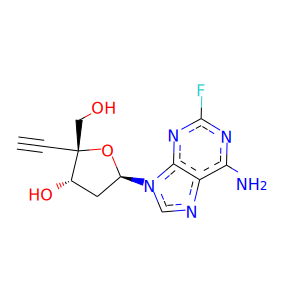

The desired reaction is:


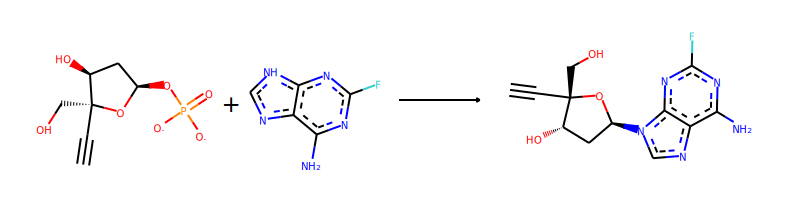



--------------------------------------------------

RANK 1 PRECEDENT
PRODUCT MATCH SCORE: 0.7706422018348624
Reaction SMILES: [NH4+:1].O=[c:3]1[nH:4][cH:5][n:6][c:7]2[c:8]1[n:9][cH:10][n:11]2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][OH:18])[O:19]1>>[NH2:1][c:3]1[n:4][cH:5][n:6][c:7]2[c:8]1[n:9][cH:10][n:11]2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][OH:18])[O:19]1
Reactant SMILES: [NH4+:1].O=[c:3]1[nH:4][cH:5][n:6][c:7]2[c:8]1[n:9][cH:10][n:11]2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][OH:18])[O:19]1
RHEA ID: 28192
Original Reaction SMILES from RHEA: O=C1NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](CO)O1.[H][N+]([H])([H])[H]>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.[H+].[H]O[H]


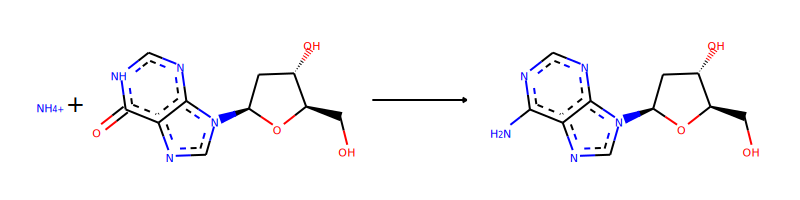

-> template: {'products': '[#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[n;H0;D2;+0:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8]', 'reactants': 'O=[c;H0;D3;+0:1]1:[nH;D2;+0:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'reaction_smarts': '([#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[n;H0;D2;+0:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8])>>O=[c;H0;D3;+0:1]1:[nH;D2;+0:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '28192', 'necessary_reagent': ''}
Precursor similarity 0.7747747747747747, overall 0.5970741383585421, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(=O)[nH]c(F)nc32)C[C@@H]1O.[NH4+]


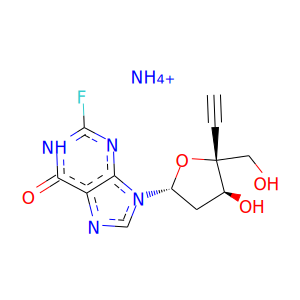



--------------------------------------------------

RANK 2 PRECEDENT
PRODUCT MATCH SCORE: 0.7706422018348624
Reaction SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O=P([O-])([O-])O[C@@H:16]1[CH2:17][C@H:18]([OH:19])[C@@H:20]([CH2:21][OH:22])[O:23]1>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[n:7]([C@H:16]3[CH2:17][C@H:18]([OH:19])[C@@H:20]([CH2:21][OH:22])[O:23]3)[cH:8][n:9][c:10]12
Reactant SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O=P([O-])([O-])O[C@@H:16]1[CH2:17][C@H:18]([OH:19])[C@@H:20]([CH2:21][OH:22])[O:23]1
RHEA ID: 27744
Original Reaction SMILES from RHEA: NC1=C2N=CNC2=NC=N1.O=P([O-])([O-])O[C@@H]1C[C@H](O)[C@@H](CO)O1>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.O=P([O-])([O-])O


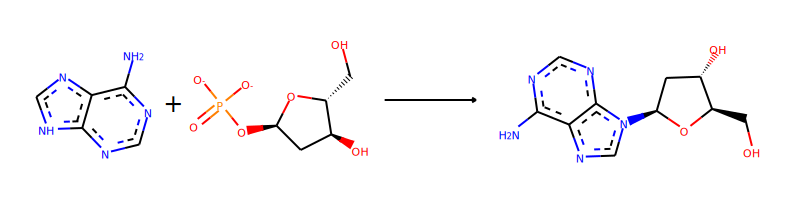

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '27744', 'necessary_reagent': ''}
Precursor similarity 0.8120300751879699, overall 0.625784645098986, smiles C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


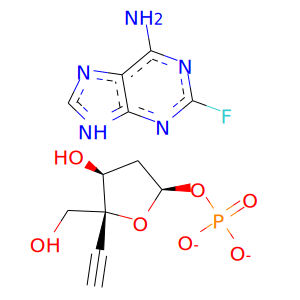



--------------------------------------------------

RANK 3 PRECEDENT
PRODUCT MATCH SCORE: 0.7706422018348624
Reaction SMILES: O=P([O-])([O-])O[CH2:16][C@@H:15]1[C@@H:13]([OH:14])[CH2:12][C@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[O:22]1.[OH2:23]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@H:11]1[CH2:12][C@H:13]([OH:14])[C@@H:15]([CH2:16][OH:23])[O:22]1
Reactant SMILES: O=P([O-])([O-])O[CH2:16][C@@H:15]1[C@@H:13]([OH:14])[CH2:12][C@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[O:22]1.[OH2:23]
RHEA ID: 29372
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H]O[H]>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.O=P([O-])([O-])O


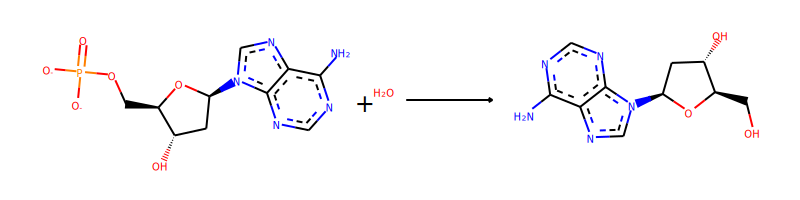

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4]', 'reactants': 'O=P(-[O-])(-[O-])-O-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4])>>O=P(-[O-])(-[O-])-O-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '29372', 'necessary_reagent': ''}
Precursor similarity 0.8091603053435115, overall 0.6235730793472932, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O


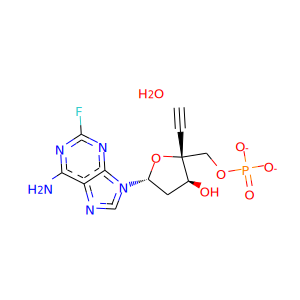



--------------------------------------------------

RANK 4 PRECEDENT
PRODUCT MATCH SCORE: 0.7706422018348624
Reaction SMILES: O=P([O-])([O-])[O:44][CH2:43][C@@H:42]1[C@@H:40]([OH:41])[CH2:39][C@H:38]([n:37]2[c:33]3[n:32][cH:31][n:30][c:29]([NH2:28])[c:34]3[n:35][cH:36]2)[O:49]1>>[NH2:28][c:29]1[n:30][cH:31][n:32][c:33]2[c:34]1[n:35][cH:36][n:37]2[C@H:38]1[CH2:39][C@H:40]([OH:41])[C@@H:42]([CH2:43][OH:44])[O:49]1
Reactant SMILES: O=P([O-])([O-])[O:44][CH2:43][C@@H:42]1[C@@H:40]([OH:41])[CH2:39][C@H:38]([n:37]2[c:33]3[n:32][cH:31][n:30][c:29]([NH2:28])[c:34]3[n:35][cH:36]2)[O:49]1
RHEA ID: 23454
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.NC1=NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H+]>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O


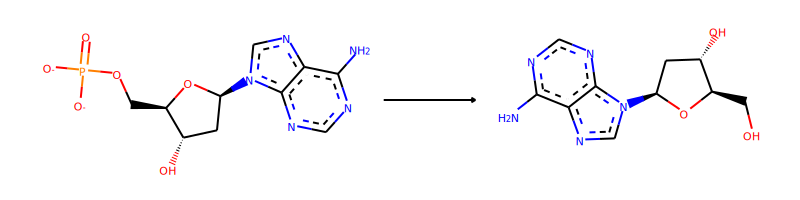

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '23454', 'necessary_reagent': ''}
Precursor similarity 0.8062015503875969, overall 0.6212929379133775, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


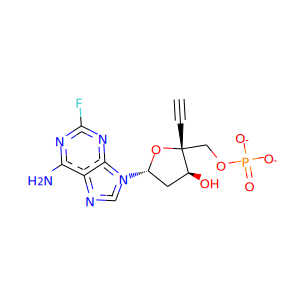

Precursor similarity 0.7441860465116279, overall 0.5735011734585023, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


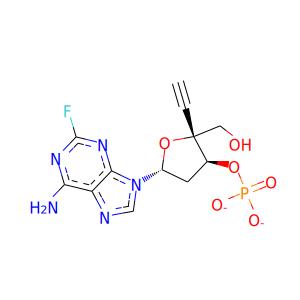



--------------------------------------------------

RANK 5 PRECEDENT
PRODUCT MATCH SCORE: 0.7706422018348624
Reaction SMILES: O=P([O-])([O-])[O:17][CH2:16][C@@H:15]1[C@@H:13]([OH:14])[CH2:12][C@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[O:22]1>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@H:11]1[CH2:12][C@H:13]([OH:14])[C@@H:15]([CH2:16][OH:17])[O:22]1
Reactant SMILES: O=P([O-])([O-])[O:17][CH2:16][C@@H:15]1[C@@H:13]([OH:14])[CH2:12][C@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[O:22]1
RHEA ID: 29372
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H]O[H]>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.O=P([O-])([O-])O


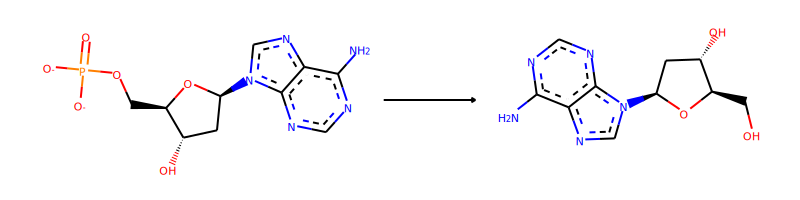

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '29372', 'necessary_reagent': ''}
Precursor similarity 0.8062015503875969, overall 0.6212929379133775, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


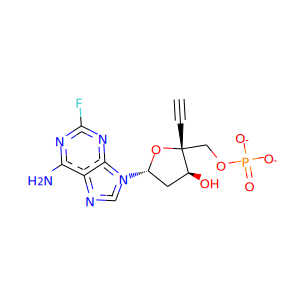

Precursor similarity 0.7441860465116279, overall 0.5735011734585023, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


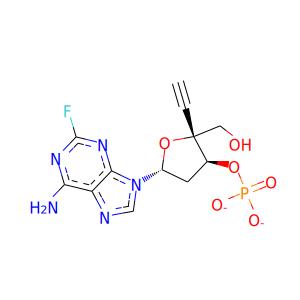



--------------------------------------------------

RANK 6 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
RHEA ID: 55205
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.NC1(CC2=CC=C(O)C=C2)C(=O)NC(=O)N/C1=N/C[C@H](O)[C@H](O)[C@H](O)CO>>CSCC[C@H]([NH3+])C(=O)[O-].C[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C32)[C@H](O)[C@@H]1O.O=C1/N=C2C(=C/C3=CC=C(O)C=C3N\2C[C@H](O)[C@H](O)[C@H](O)CO)C(=O)[N-]1.[H+].[H][N+]([H])([H])[H]

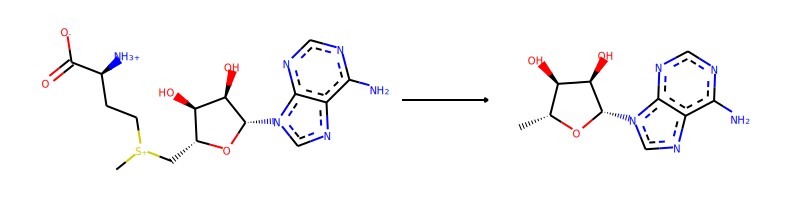

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '55205', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 7 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: O=P([O-])([O-])O[C@H:4]1[O:3][C@H:2]([CH3:1])[C@@H:12]([OH:13])[C@H:10]1[OH:11].[NH2:14][c:15]1[n:16][cH:17][n:18][c:19]2[nH:20][cH:21][n:22][c:23]12>>[CH3:1][C@H:2]1[O:3][C@@H:4]([n:20]2[c:19]3[n:18][cH:17][n:16][c:15]([NH2:14])[c:23]3[n:22][cH:21]2)[C@H:10]([OH:11])[C@@H:12]1[OH:13]
Reactant SMILES: O=P([O-])([O-])O[C@H:4]1[O:3][C@H:2]([CH3:1])[C@@H:12]([OH:13])[C@H:10]1[OH:11].[NH2:14][c:15]1[n:16][cH:17][n:18][c:19]2[nH:20][cH:21][n:22][c:23]12
RHEA ID: 24871
Original Reaction SMIL

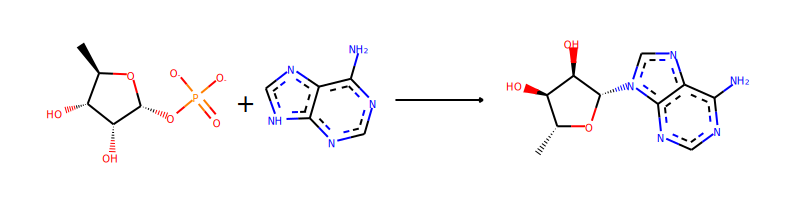

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '24871', 'necessary_reagent': ''}
Precursor similarity 0.7575757575757576, overall 0.5331088664421998, smiles C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


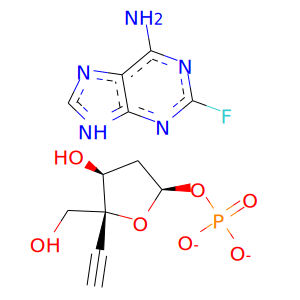



--------------------------------------------------

RANK 8 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
RHEA ID: 27374
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.NC1=C(NC[C@H](O)[C@H](O)[C@H](O)CO)NC(=O)NC1=O.[NH3+][C@@H](CC1=CC=C(O)C=C1)C(=O)[O-]>>CSCC[C@H]([NH3+])C(=O)[O-].CSCC[C@H]([NH3+])C(=O)[O-].C[C@H]1O[C@@H](N2C=

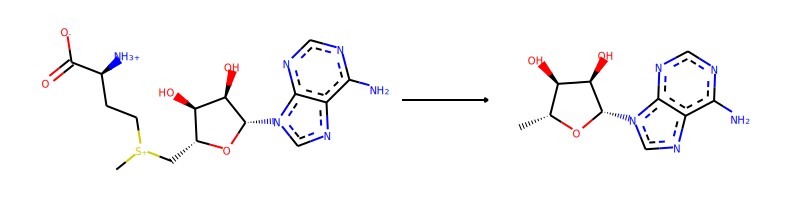

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 27374, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 9 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:55][C@H:56]1[O:57][C@@H:58]([n:59]2[cH:60][n:61][c:62]3[c:63]([NH2:64])[n:65][cH:66][n:67][c:68]23)[C@H:69]([OH:70])[C@@H:71]1[OH:72]>>[CH3:55][C@H:56]1[O:57][C@@H:58]([n:59]2[cH:60][n:61][c:62]3[c:63]([NH2:64])[n:65][cH:66][n:67][c:68]23)[C@H:69]([OH:70])[C@@H:71]1[OH:72]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:55][C@H:56]1[O:57][C@@H:58]([n:59]2[cH:60][n:61][c:62]3[c:63]([NH2:64])[n:65][cH:66][n:67][c:68]23)[C@H:69]([OH:70])[C@@H:71]1[OH

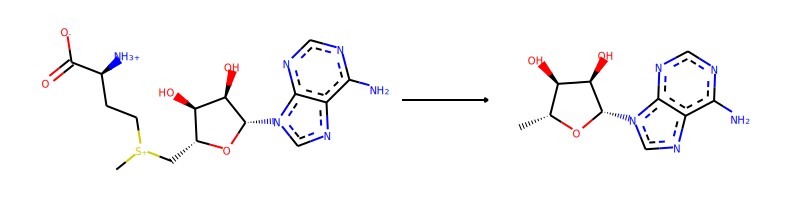

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '13342', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 10 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54]>>[CH3:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1

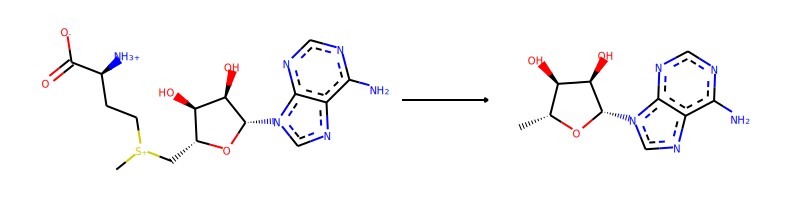

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 15426, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 11 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: O[c:9]1[c:8]2[n:7][cH:6][n:5]([C@@H:4]3[O:3][C@H:2]([CH3:1])[C@@H:17]([OH:18])[C@H:15]3[OH:16])[c:14]2[n:13][cH:12][n:11]1.[NH4+:19]>>[CH3:1][C@H:2]1[O:3][C@@H:4]([n:5]2[cH:6][n:7][c:8]3[c:9]([NH2:19])[n:11][cH:12][n:13][c:14]23)[C@H:15]([OH:16])[C@@H:17]1[OH:18]
Reactant SMILES: O[c:9]1[c:8]2[n:7][cH:6][n:5]([C@@H:4]3[O:3][C@H:2]([CH3:1])[C@@H:17]([OH:18])[C@H:15]3[OH:16])[c:14]2[n:13][cH:12][n:11]1.[NH4+:19]
RHEA ID: 42894
Original Reaction SMILES from RHEA: C[C@H]1O[C@@H](N2C=NC3=C(O

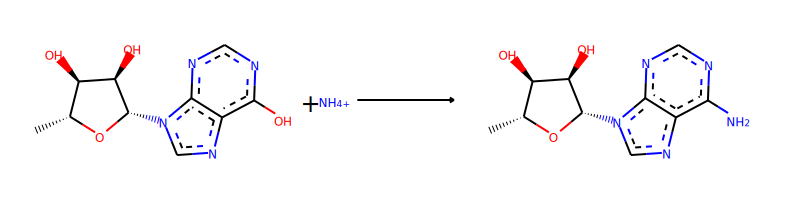

-> template: {'products': '[#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[#7;a:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8]', 'reactants': 'O-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'reaction_smarts': '([#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[#7;a:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8])>>O-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '42894', 'necessary_reagent': ''}
Precursor similarity 0.7090909090909091, overall 0.49898989898989904, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(O)nc(F)nc32)C[C@@H]1O.[NH4+]


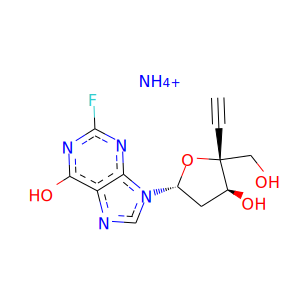



--------------------------------------------------

RANK 12 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
RHEA ID: 33084
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.O=C([O-])C1=CC(C(=O)CC[C@H]2OC(O)[C@H](O)[C@@H]2O)=CC=C1>>CSCC[C@H]([NH3+])C(=O)[O-].C[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C32)[C@H](O)[C@@H]1O.O=C([O-])C1=CC2=C(C=C1)[C@@]1(CCC2=O)OC(O)[C@H](O)[C@@H]1O.[H+]


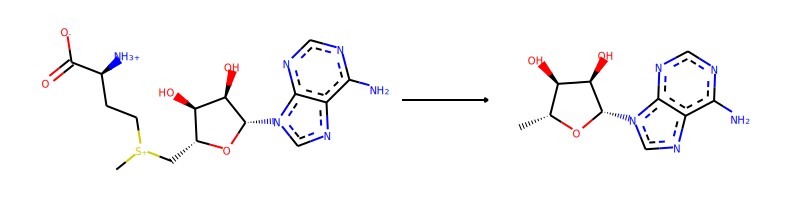

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '33084', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 13 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:27][C@H:28]1[O:29][C@@H:30]([n:31]2[cH:32][n:33][c:34]3[c:35]([NH2:36])[n:37][cH:38][n:39][c:40]23)[C@H:41]([OH:42])[C@@H:43]1[OH:44]>>[CH3:27][C@H:28]1[O:29][C@@H:30]([n:31]2[cH:32][n:33][c:34]3[c:35]([NH2:36])[n:37][cH:38][n:39][c:40]23)[C@H:41]([OH:42])[C@@H:43]1[OH:44]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:27][C@H:28]1[O:29][C@@H:30]([n:31]2[cH:32][n:33][c:34]3[c:35]([NH2:36])[n:37][cH:38][n:39][c:40]23)[C@H:41]([OH:42])[C@@H:43]1

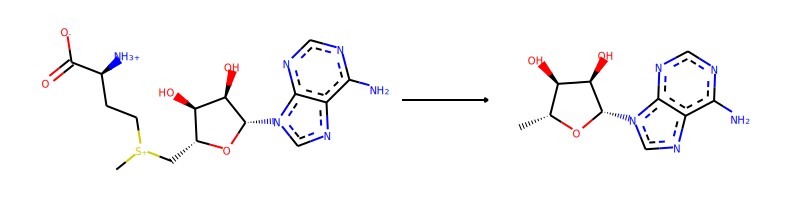

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '57701', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 14 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: O[C@H:4]1[O:3][C@H:2]([CH3:1])[C@@H:8]([OH:9])[C@H:6]1[OH:7].[NH2:10][c:11]1[n:12][cH:13][n:14][c:15]2[nH:16][cH:17][n:18][c:19]12>>[CH3:1][C@H:2]1[O:3][C@@H:4]([n:16]2[c:15]3[n:14][cH:13][n:12][c:11]([NH2:10])[c:19]3[n:18][cH:17]2)[C@H:6]([OH:7])[C@@H:8]1[OH:9]
Reactant SMILES: O[C@H:4]1[O:3][C@H:2]([CH3:1])[C@@H:8]([OH:9])[C@H:6]1[OH:7].[NH2:10][c:11]1[n:12][cH:13][n:14][c:15]2[nH:16][cH:17][n:18][c:19]12
RHEA ID: 29861
Original Reaction SMILES from RHEA: C[C@H]1O[C@H](O)[C@H](O)[C@

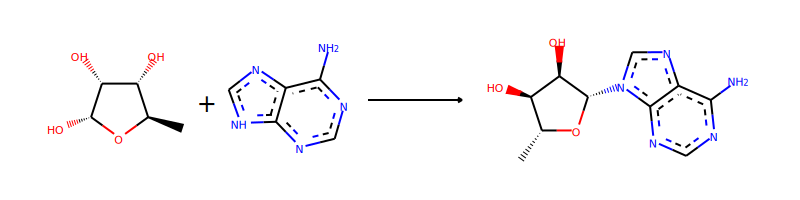

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '29861', 'necessary_reagent': ''}
Precursor similarity 0.7142857142857143, overall 0.5026455026455027, smiles C#C[C@]1(CO)O[C@H](O)C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


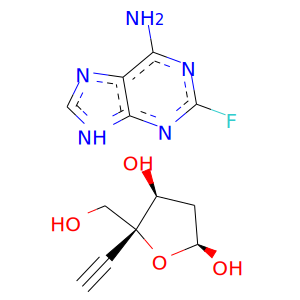



--------------------------------------------------

RANK 15 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
RHEA ID: 26362
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[NH3+][C@@H](CC1=CC=C(O)C=C1)C(=O)[O-]>>CC1=CC=C(O)C=C1.CSCC[C@H]([NH3+])C(=O)[O-].C[C@H]1O[C@@H](N2

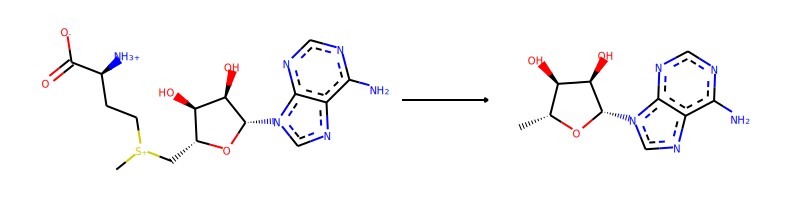

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '26362', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 16 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1

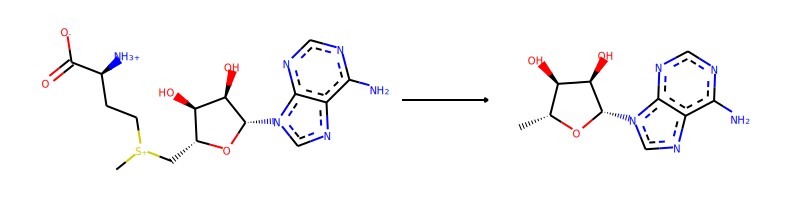

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 15426, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 17 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[O

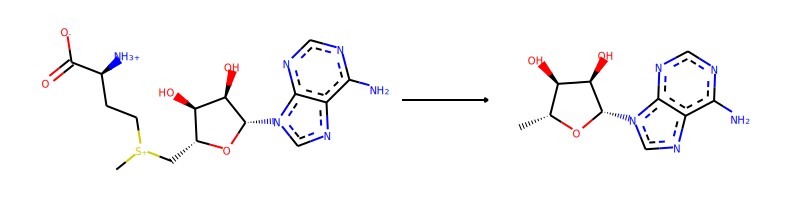

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '55201', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 18 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]>>[CH3:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1

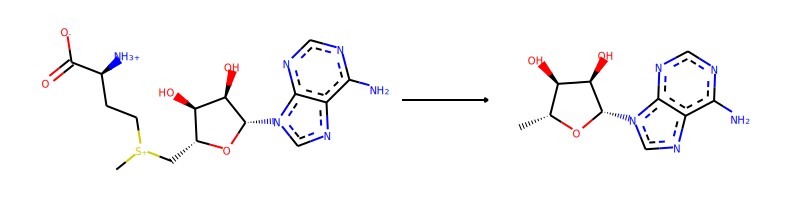

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '34276', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 19 PRECEDENT
PRODUCT MATCH SCORE: 0.7037037037037037
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54]>>[CH3:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1

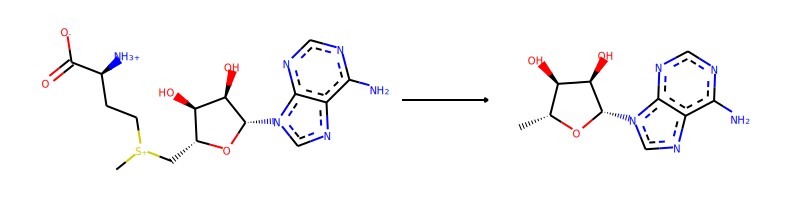

-> template: {'products': '[#8:3]-[C:2]-[CH3;D1;+0:1]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3]', 'reaction_smarts': '([#8:3]-[C:2]-[CH3;D1;+0:1])>>(C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 27374, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 20 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]
RHEA ID: 52534
Original Reaction SMI

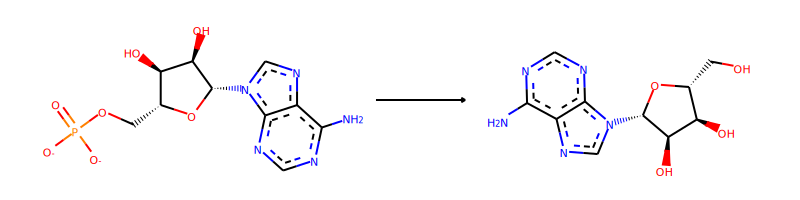

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '52534', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.5256859913348464, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


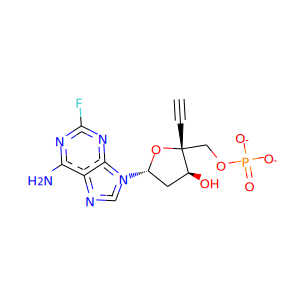

Precursor similarity 0.7022900763358778, overall 0.4935011347225088, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


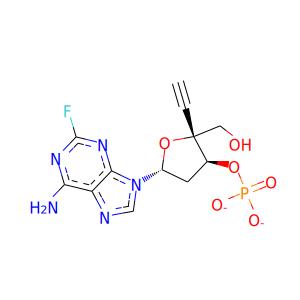



--------------------------------------------------

RANK 21 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=[C:14]([C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:19]([OH:20])[C@@H:17]1[OH:18])[O-:16]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:16])[C@@H:17]([OH:18])[C@H:19]1[OH:20]
Reactant SMILES: O=[C:14]([C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:19]([OH:20])[C@@H:17]1[OH:18])[O-:16]
RHEA ID: 15491
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](C(=O)[O-])[C@@H](O)[C@H]1O.[H+].[H]OO[H].[H]OO[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=O.O=O.[H]O[H]


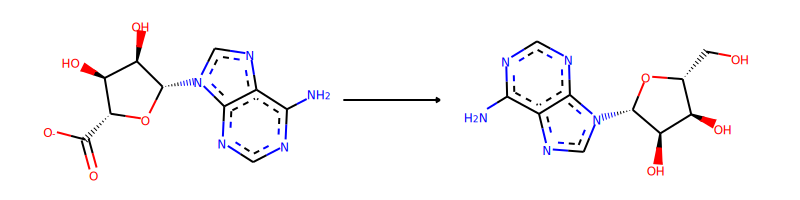

-> template: {'products': '[#8:4]-[C:3]-[CH2;D2;+0:1]-[OH;D1;+0:2]', 'reactants': 'O=[C;H0;D3;+0:1](-[O-;H0;D1:2])-[C:3]-[#8:4]', 'reaction_smarts': '([#8:4]-[C:3]-[CH2;D2;+0:1]-[OH;D1;+0:2])>>(O=[C;H0;D3;+0:1](-[O-;H0;D1:2])-[C:3]-[#8:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '15491', 'necessary_reagent': ''}
Precursor similarity 0.7130434782608696, overall 0.5010575793184489, smiles C#C[C@]1(C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


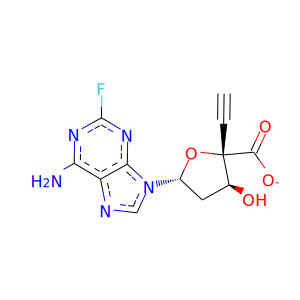



--------------------------------------------------

RANK 22 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[OH2:28]>>[CH2:10]([C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])[OH:28]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[OH2:28]
RHEA ID: 56141
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.[H]O[H]>>CSCC[C@H]([NH3+])C(=O)[O-].NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.[H+]


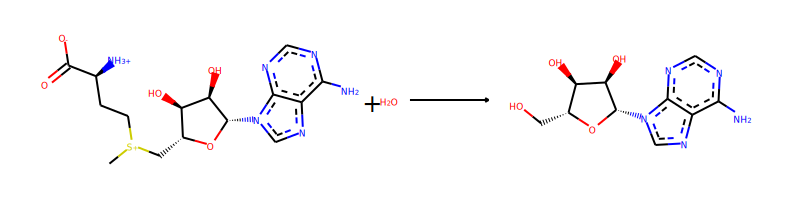

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4])>>C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '56141', 'necessary_reagent': ''}
Precursor similarity 0.7870967741935484, overall 0.5530950305143854, smiles C#C[C@]1(C[S+](C)CC[C@H]([NH3+])C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O


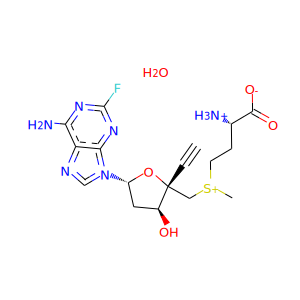



--------------------------------------------------

RANK 23 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])[O:17][C@@H:16]1[C@@H:13]([CH2:14][OH:15])[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@@H:22]1[OH:23]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:16]([OH:17])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])[O:17][C@@H:16]1[C@@H:13]([CH2:14][OH:15])[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@@H:22]1[OH:23]
RHEA ID: 27899
Original Reaction SMILES from RHEA: NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](OP(=O)([O-])[O-])[C@H]3O)C2=NC=N1.[H]O[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O


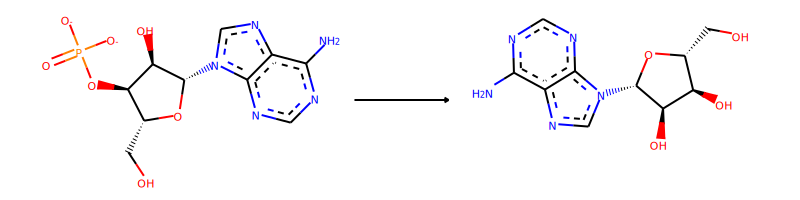

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '27899', 'necessary_reagent': ''}
Precursor similarity 0.7022900763358778, overall 0.4935011347225088, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


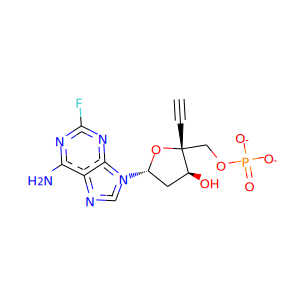

Precursor similarity 0.7480916030534351, overall 0.5256859913348464, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


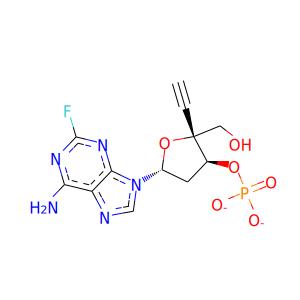



--------------------------------------------------

RANK 24 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])O[C@@H:16]1[C@@H:13]([CH2:14][OH:15])[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@@H:22]1[OH:23].[OH2:24]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:16]([OH:24])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])O[C@@H:16]1[C@@H:13]([CH2:14][OH:15])[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@@H:22]1[OH:23].[OH2:24]
RHEA ID: 27899
Original Reaction SMILES from RHEA: NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](OP(=O)([O-])[O-])[C@H]3O)C2=NC=N1.[H]O[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O


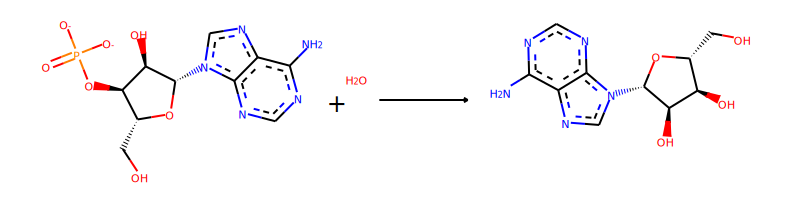

-> template: {'products': '[#8:4]-[C:3]-[C@@H;D3;+0:1](-[C:2])-[OH;D1;+0:5]', 'reactants': 'O=P(-[O-])(-[O-])-O-[C@H;D3;+0:1](-[C:2])-[C:3]-[#8:4].[OH2;D0;+0:5]', 'reaction_smarts': '([#8:4]-[C:3]-[C@@H;D3;+0:1](-[C:2])-[OH;D1;+0:5])>>O=P(-[O-])(-[O-])-O-[C@H;D3;+0:1](-[C:2])-[C:3]-[#8:4].[OH2;D0;+0:5]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '27899', 'necessary_reagent': ''}
Precursor similarity 0.7518796992481203, overall 0.5283478967689494, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-].O


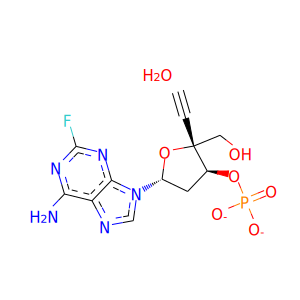



--------------------------------------------------

RANK 25 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])O[CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21].[OH2:24]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:24])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])O[CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21].[OH2:24]
RHEA ID: 29376
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H]O[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O


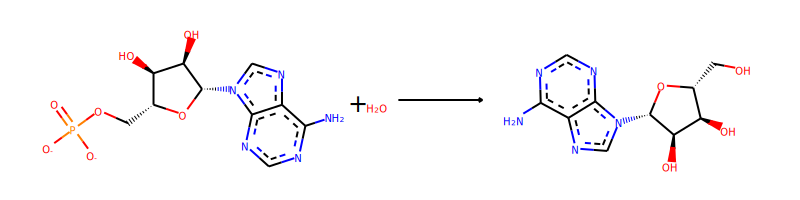

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4]', 'reactants': 'O=P(-[O-])(-[O-])-O-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4])>>O=P(-[O-])(-[O-])-O-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '29376', 'necessary_reagent': ''}
Precursor similarity 0.7518796992481203, overall 0.5283478967689494, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O


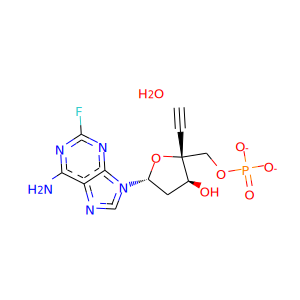



--------------------------------------------------

RANK 26 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: Cc1cn([C@H]2C[C@H](O)[C@@H]([CH2:10][OH:11])O2)c(=O)[nH]c1=O.O=P([O-])([O-])OC[C@H:30]1[O:29][C@@H:28]([n:27]2[c:23]3[n:22][cH:21][n:20][c:19]([NH2:18])[c:24]3[n:25][cH:26]2)[C@H:39]([OH:40])[C@@H:37]1[OH:38]>>[CH2:10]([OH:11])[C@H:30]1[O:29][C@@H:28]([n:27]2[c:23]3[n:22][cH:21][n:20][c:19]([NH2:18])[c:24]3[n:25][cH:26]2)[C@H:39]([OH:40])[C@@H:37]1[OH:38]
Reactant SMILES: Cc1cn([C@H]2C[C@H](O)[C@@H]([CH2:10][OH:11])O2)c(=O)[nH]c1=O.O=P([O-])([O-])OC[C@H:30]1[O:29][C@@H:28]([n:27]2[c:23]3[n:22][cH:21][n:20][c:19]([NH2:18])[c:24]3[n:25][cH:26]2)[C@H:39]([OH:40])[C@@H:37]1[OH:38]
RHEA ID: 14914
Original Reaction SMILES from RHEA: CC1=CN([C@H]2C[C@H](O)[C@@H](CO)O2)C(=O)NC1=O.NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O>>CC1=CN([C@H]2C[C@H](O)[C@@H](COP(=O)([O-])[O-])O2)C(=O)NC1=O.NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1


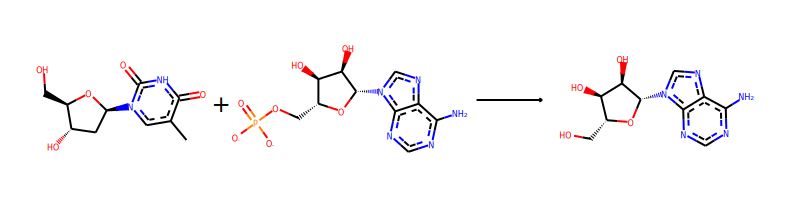

-> template: {'products': '[#8:4]-[C@@H;D3;+0:3](-[C:5])-[CH2;D2;+0:1]-[O;D1;H1:2]', 'reactants': 'C-c1:c:n(-[C@H]2-C-[C@H](-O)-[C@@H](-[CH2;D2;+0:1]-[O;D1;H1:2])-O-2):c(=O):[nH]:c:1=O.O=P(-[O-])(-[O-])-O-C-[C@@H;D3;+0:3](-[#8:4])-[C:5]', 'reaction_smarts': '([#8:4]-[C@@H;D3;+0:3](-[C:5])-[CH2;D2;+0:1]-[O;D1;H1:2])>>C-c1:c:n(-[C@H]2-C-[C@H](-O)-[C@@H](-[CH2;D2;+0:1]-[O;D1;H1:2])-O-2):c(=O):[nH]:c:1=O.O=P(-[O-])(-[O-])-O-C-[C@@H;D3;+0:3](-[#8:4])-[C:5]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '14914', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 27 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: C/C(=C\C[n+:5]1[cH:6][n:7][c:8]2[c:9]([n:10][cH:11][n:12]2[C@@H:13]2[O:14][C@H:15]([CH2:16][OH:17])[C@@H:18]([OH:19])[C@H:20]2[OH:21])[c:22]1[NH2:23])CC[C@]1(C)[C@@H](C)CC=C2[C@H]1CCCC2(C)C>>[n:5]1[cH:6][n:7][c:8]2[c:9]([n:10][cH:11][n:12]2[C@@H:13]2[O:14][C@H:15]([CH2:16][OH:17])[C@@H:1

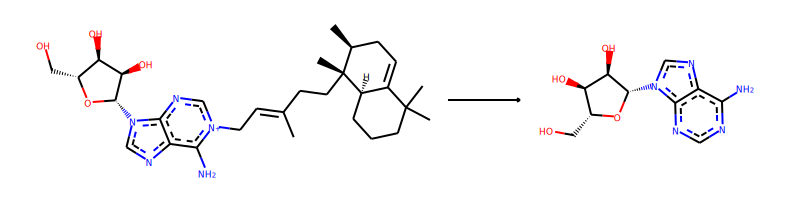

-> template: {'products': '[#7;a:4]:[c:3]:[c:2]:[n;H0;D2;+0:1]:[c:5]:[#7;a:6]', 'reactants': 'C/C(-C-C-[C@]1(-C)-[C@@H](-C)-C-C=C2-[C@H]-1-C-C-C-C-2(-C)-C)=C\\C-[n+;H0;D3:1](:[c:2]:[c:3]:[#7;a:4]):[c:5]:[#7;a:6]', 'reaction_smarts': '([#7;a:4]:[c:3]:[c:2]:[n;H0;D2;+0:1]:[c:5]:[#7;a:6])>>(C/C(-C-C-[C@]1(-C)-[C@@H](-C)-C-C=C2-[C@H]-1-C-C-C-C-2(-C)-C)=C\\C-[n+;H0;D3:1](:[c:2]:[c:3]:[#7;a:4]):[c:5]:[#7;a:6])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '46002', 'necessary_reagent': ''}
Precursor similarity 0.7782805429864253, overall 0.5468998410174881, smiles C#C[C@]1(CO)O[C@@H](n2c[n+](C/C=C(\C)CC[C@]3(C)[C@@H](C)CC=C4[C@H]3CCCC4(C)C)c3c(N)nc(F)nc32)C[C@@H]1O


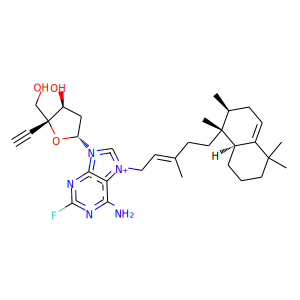

Precursor similarity 0.8506787330316742, overall 0.5977742448330684, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)[n+](C/C=C(\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c(F)nc32)C[C@@H]1O


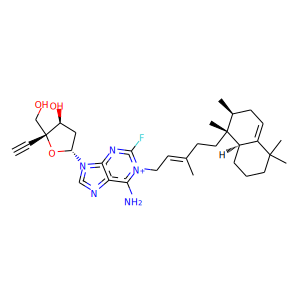

Precursor similarity 0.7963800904977375, overall 0.5596184419713831, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)[n+](C/C=C(\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c32)C[C@@H]1O


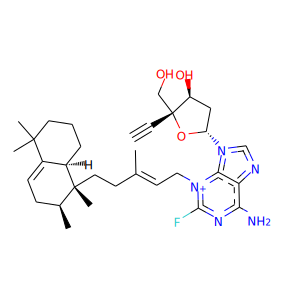



--------------------------------------------------

RANK 28 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: [NH4+:1].O[c:11]1[c:10]2[n:9][cH:8][n:7]([C@@H:6]3[O:5][C@H:4]([CH2:3][OH:2])[C@@H:19]([OH:20])[C@H:17]3[OH:18])[c:16]2[n:15][cH:14][n:13]1>>[NH2:1][c:11]1[c:10]2[n:9][cH:8][n:7]([C@@H:6]3[O:5][C@H:4]([CH2:3][OH:2])[C@@H:19]([OH:20])[C@H:17]3[OH:18])[c:16]2[n:15][cH:14][n:13]1
Reactant SMILES: [NH4+:1].O[c:11]1[c:10]2[n:9][cH:8][n:7]([C@@H:6]3[O:5][C@H:4]([CH2:3][OH:2])[C@@H:19]([OH:20])[C@H:17]3[OH:18])[c:16]2[n:15][cH:14][n:13]1
RHEA ID: 24410
Original Reaction SMILES from RHEA: OC[C@H]1O[C@@H](N2C=NC3=C(O)N=CN=C32)[C@H](O)[C@@H]1O.[H][N+]([H])([H])[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.[H+].[H]O[H]


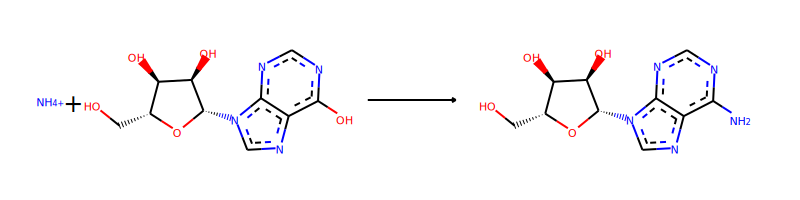

-> template: {'products': '[#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[#7;a:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8]', 'reactants': 'O-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'reaction_smarts': '([#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[#7;a:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8])>>O-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '24410', 'necessary_reagent': ''}
Precursor similarity 0.7079646017699115, overall 0.49748863908155944, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(O)nc(F)nc32)C[C@@H]1O.[NH4+]


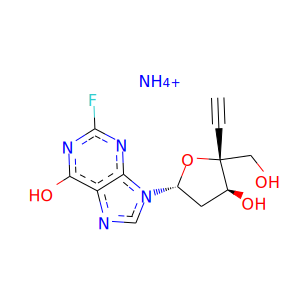



--------------------------------------------------

RANK 29 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]
RHEA ID: 29376
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H]O[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O


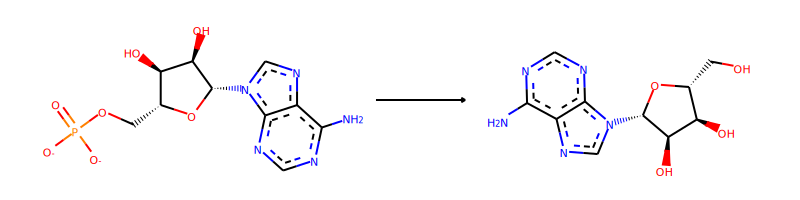

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '29376', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.5256859913348464, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


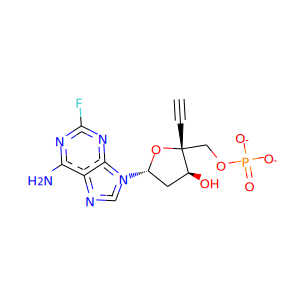

Precursor similarity 0.7022900763358778, overall 0.4935011347225088, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


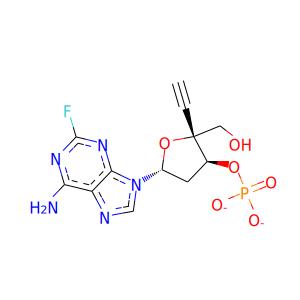



--------------------------------------------------

RANK 30 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O=P([O-])([O-])O[C@H:16]1[O:17][C@H:18]([CH2:19][OH:20])[C@@H:21]([OH:22])[C@H:23]1[OH:24]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[n:7]([C@@H:16]3[O:17][C@H:18]([CH2:19][OH:20])[C@@H:21]([OH:22])[C@H:23]3[OH:24])[cH:8][n:9][c:10]12
Reactant SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O=P([O-])([O-])O[C@H:16]1[O:17][C@H:18]([CH2:19][OH:20])[C@@H:21]([OH:22])[C@H:23]1[OH:24]
RHEA ID: 27644
Original Reaction SMILES from RHEA: NC1=C2N=CNC2=NC=N1.O=P([O-])([O-])O[C@H]1O[C@H](CO)[C@@H](O)[C@H]1O>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O


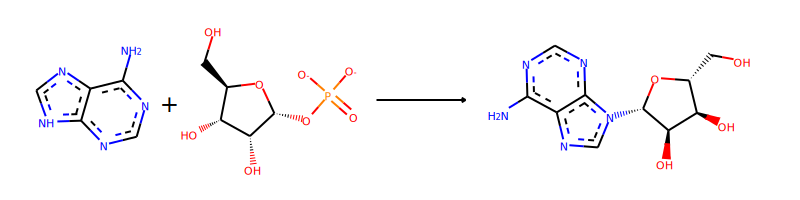

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '27644', 'necessary_reagent': ''}
Precursor similarity 0.7555555555555555, overall 0.5309309309309309, smiles C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


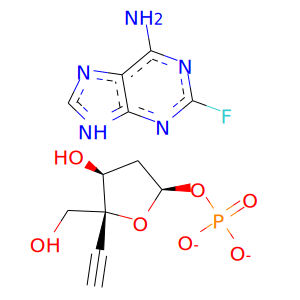



--------------------------------------------------

RANK 31 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH:14]=[O:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
Reactant SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH:14]=[O:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
RHEA ID: 18187
Original Reaction SMILES from RHEA: [H]C(=O)[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C32)[C@H](O)[C@@H]1O.[H]OO[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.O=O


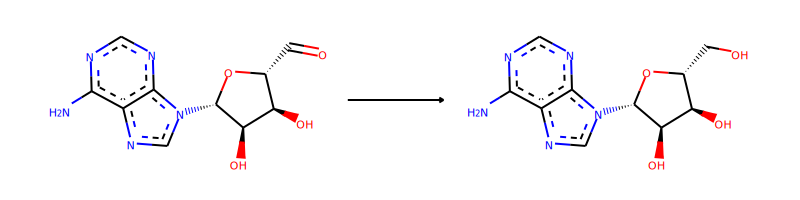

-> template: {'products': '[#8:1]-[C:2]-[CH2;D2;+0:3]-[OH;D1;+0:4]', 'reactants': '[#8:1]-[C:2]-[CH;D2;+0:3]=[O;H0;D1;+0:4]', 'reaction_smarts': '([#8:1]-[C:2]-[CH2;D2;+0:3]-[OH;D1;+0:4])>>([#8:1]-[C:2]-[CH;D2;+0:3]=[O;H0;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '18187', 'necessary_reagent': ''}
Precursor similarity 0.7027027027027027, overall 0.49379108838568303, smiles C#C[C@]1(C=O)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


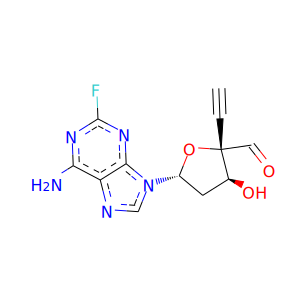



--------------------------------------------------

RANK 32 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[F-:28]>>[CH2:10]([C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])[F:28]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[F-:28]
RHEA ID: 16662
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.[F-]>>CSCC[C@H]([NH3+])C(=O)[O-].NC1=C2N=CN([C@@H]3O[C@H](CF)[C@@H](O)[C@H]3O)C2=NC=N1


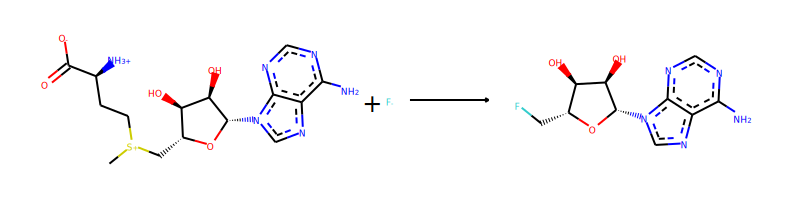

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[F;H0;D1;+0:4]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[F-;H0;D0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[F;H0;D1;+0:4])>>C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[F-;H0;D0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '16662', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 33 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O[CH:15]1[O:14][C@H:13]([CH2:12][OH:11])[C@@H:19]([OH:20])[C@H:17]1[OH:18]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[n:7]([C@@H:15]3[O:14][C@H:13]([CH2:12][OH:11])[C@@H:19]([OH:20])[C@H:17]3[OH:18])[cH:8][n:9][c:10]12
Reactant SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[nH:7][cH:8][n:9][c:10]12.O[CH:15]1[O:14][C@H:13]([CH2:12][OH:11])[C@@H:19]([OH:20])[C@H:17]1[OH:18]
RHEA ID

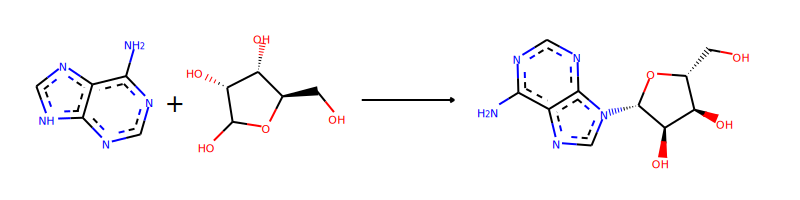

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O-[CH;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O-[CH;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '18671', 'necessary_reagent': ''}
Precursor similarity 0.7130434782608696, overall 0.5010575793184489, smiles C#C[C@]1(CO)OC(O)C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


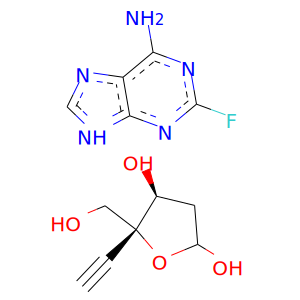



--------------------------------------------------

RANK 34 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[Cl-:28]>>[CH2:10]([C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])[Cl:28]
Reactant SMILES: C[S+](CC[C@H]([NH3+])C(=O)[O-])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27].[Cl-:28]
RHEA ID: 28111
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.[Cl-]>>CSCC[C@H]([NH3+])C(=O)[O-].NC1=C2N=CN([C@@H]3O[C@H](CCl)[C@@H](O)[C@H]3O)C2=NC=N1


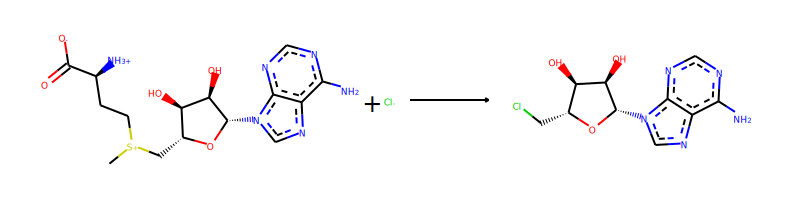

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[Cl;H0;D1;+0:4]', 'reactants': 'C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[Cl-;H0;D0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[Cl;H0;D1;+0:4])>>C-[S+](-C-C-[C@H](-[NH3+])-C(=O)-[O-])-[CH2;D2;+0:1]-[C:2]-[#8:3].[Cl-;H0;D0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '28111', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 35 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([

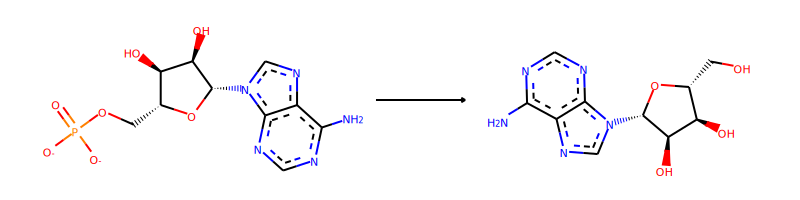

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '20826', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.5256859913348464, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


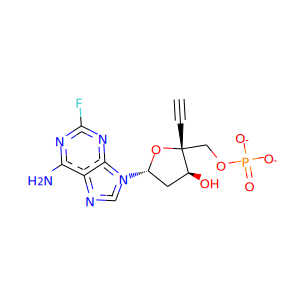

Precursor similarity 0.7022900763358778, overall 0.4935011347225088, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


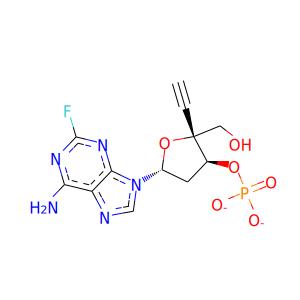



--------------------------------------------------

RANK 36 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: [NH3+][C@@H](CCS[CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:25]([OH:26])[C@@H:23]1[OH:24])C(=O)[O-].[OH2:27]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:27])[C@@H:23]([OH:24])[C@H:25]1[OH:26]
Reactant SMILES: [NH3+][C@@H](CCS[CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:25]([OH:26])[C@@H:23]1[OH:24])C(=O)[O-].[OH2:27]
RHEA ID: 21709
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](CSCC[C@H]([NH3+])C(=O)[O-])[C@@H](O)[C@H]1O.[H]O[H]>>NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1.[NH3+][C@@H](CCS)C(=O)[O-]


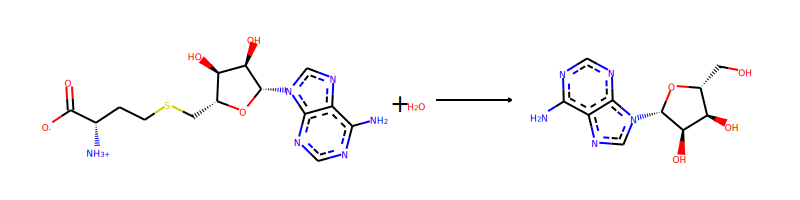

-> template: {'products': '[#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-S-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:3]-[C:2]-[CH2;D2;+0:1]-[OH;D1;+0:4])>>O=C(-[O-])-[C@@H](-[NH3+])-C-C-S-[CH2;D2;+0:1]-[C:2]-[#8:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '21709', 'necessary_reagent': ''}
Precursor similarity 0.7814569536423841, overall 0.549131913370324, smiles C#C[C@]1(CSCC[C@H]([NH3+])C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O


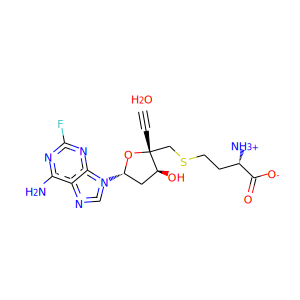



--------------------------------------------------

RANK 37 PRECEDENT
PRODUCT MATCH SCORE: 0.7027027027027027
Reaction SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: O=P([O-])([O-])[O:15][CH2:14][C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:22]([OH:23])[C@@H:20]1[OH:21]
RHEA ID: 52538
Original Reaction SMILES from RHEA: N/C1=N/C2=C(N=CN2[C@H]2C[C@H](O)[C@@H](COP(=O)([O-])OP(=O)([O-])[O-])O2)C(=O)N1.NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H+]>>N/C1=N/C2=C(N=CN2[C@H]2C[C@H](O)[C@@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])O2)C(=O)N1.NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O)C2=NC=N1


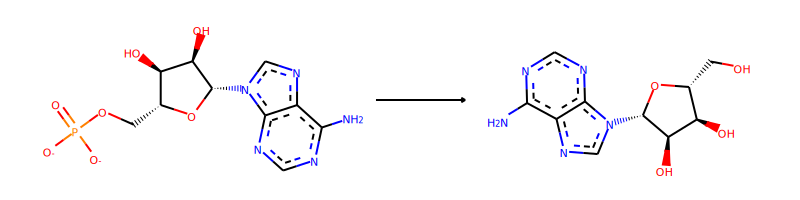

-> template: {'products': '[C:2]-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2]', 'reaction_smarts': '([C:2]-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C:2])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '52538', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.5256859913348464, smiles C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O


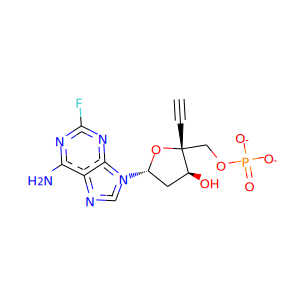

Precursor similarity 0.7022900763358778, overall 0.4935011347225088, smiles C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]


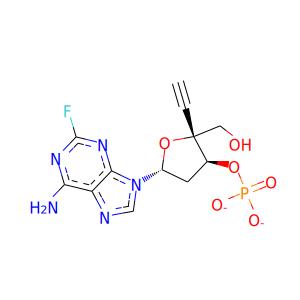



--------------------------------------------------

RANK 38 PRECEDENT
PRODUCT MATCH SCORE: 0.6846846846846847
Reaction SMILES: [O-][C:14]([C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:19]([OH:20])[C@@H:17]1[OH:18])=[O:15]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH:14]=[O:15])[C@@H:17]([OH:18])[C@H:19]1[OH:20]
Reactant SMILES: [O-][C:14]([C@H:13]1[O:12][C@@H:11]([n:10]2[c:6]3[n:5][cH:4][n:3][c:2]([NH2:1])[c:7]3[n:8][cH:9]2)[C@H:19]([OH:20])[C@@H:17]1[OH:18])=[O:15]
RHEA ID: 22542
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](C(=O)[O-])[C@@H](O)[C@H]1O.[H+].[H]OO[H]>>O=O.[H]C(=O)[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C32)[C@H](O)[C@@H]1O.[H]O[H]


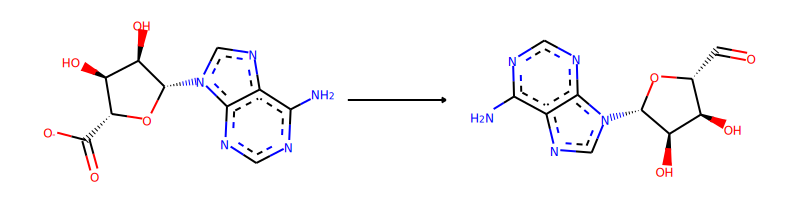

-> template: {'products': '[#8:1]-[C:2]-[CH;D2;+0:3]=[O;D1;H0:4]', 'reactants': '[#8:1]-[C:2]-[C;H0;D3;+0:3](-[O-])=[O;D1;H0:4]', 'reaction_smarts': '([#8:1]-[C:2]-[CH;D2;+0:3]=[O;D1;H0:4])>>([#8:1]-[C:2]-[C;H0;D3;+0:3](-[O-])=[O;D1;H0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '22542', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 39 PRECEDENT
PRODUCT MATCH SCORE: 0.6846846846846847
Reaction SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH:14]=[O:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
Reactant SMILES: [NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][OH:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
RHEA ID: 18186
Original Reaction SMILES from RHEA: NC1=C2N=CN([C@@H]3O[C@H](CO)[C@@

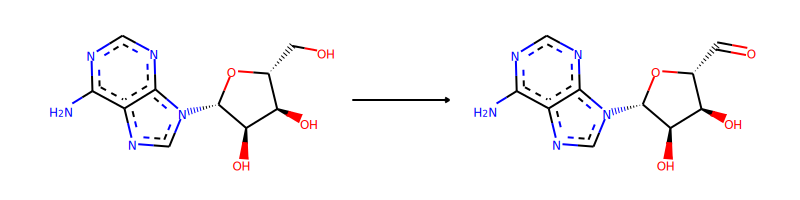

-> template: {'products': '[#8:1]-[C:2]-[CH;D2;+0:3]=[O;H0;D1;+0:4]', 'reactants': '[#8:1]-[C:2]-[CH2;D2;+0:3]-[OH;D1;+0:4]', 'reaction_smarts': '([#8:1]-[C:2]-[CH;D2;+0:3]=[O;H0;D1;+0:4])>>([#8:1]-[C:2]-[CH2;D2;+0:3]-[OH;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '18186', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 40 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:17]([CH3:16])[CH2:25][C@H:26]1[O:27][C@@H:28]([n:29]2[cH:30][n:31][c:32]3[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]23)[C@H:39]([OH:40])[C@@H:41]1[OH:42])C(=O)[O-]>>[CH3:16][S:17][CH2:25][C@H:26]1[O:27][C@@H:28]([n:29]2[cH:30][n:31][c:32]3[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]23)[C@H:39]([OH:40])[C@@H:41]1[OH:42]
Reactant SMILES: [NH3+][C@@H](CC[S+:17]([CH3:16])[CH2:25][C@H:26]1[O:27][C@@H:28]([n:29]2[cH:30][n:31][c:32]3[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]23)[C@H:39]([OH:40])[C@@H:41

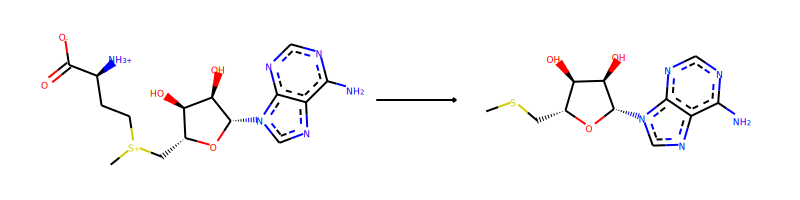

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '19582', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 41 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:56]([CH3:55])[CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c:77]23)[C@H:78]([OH:79])[C@@H:80]1[OH:81])C(=O)[O-]>>[CH3:55][S:56][CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c:77]23)[C@H:78]([OH:79])[C@@H:80]1[OH:81]
Reactant SMILES: [NH3+][C@@H](CC[S+:56]([CH3:55])[CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c

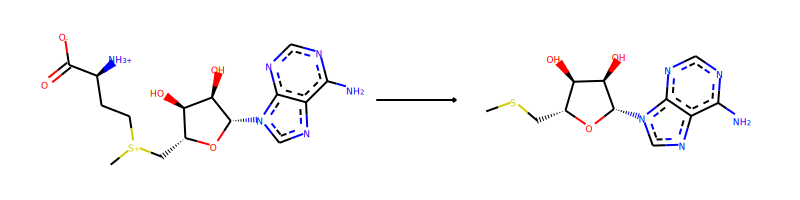

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 16482, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 42 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])C(=O)[O-]>>[CH3:1][S:2][CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[

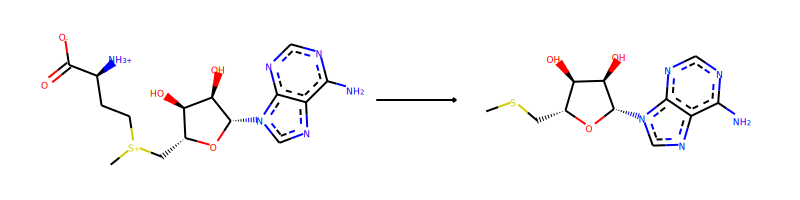

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 16482, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 43 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])C(=O)[O-]>>[CH3:1][S:2][CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[

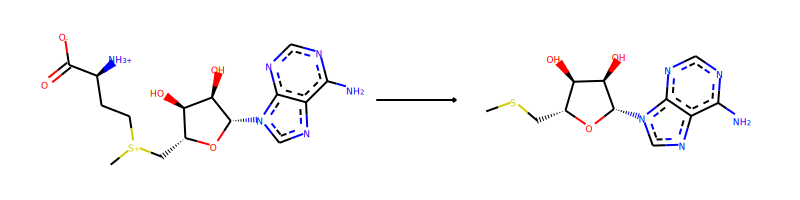

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '59089', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 44 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]>>[CH3:1][S:2][CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]
Reactant SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH

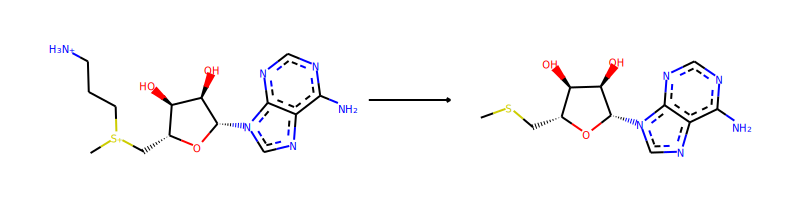

-> template: {'products': '[C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3]', 'reactants': '[C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+]', 'reaction_smarts': '([C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3])>>([C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '42881', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 45 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:56]([CH3:55])[CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c:77]23)[C@H:78]([OH:79])[C@@H:80]1[OH:81])C(=O)[O-]>>[CH3:55][S:56][CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c:77]23)[C@H:78]([OH:79])[C@@H:80]1[OH:81]
Reactant SMILES: [NH3+][C@@H](CC[S+:56]([CH3:55])[CH2:64][C@H:65]1[O:66][C@@H:67]([n:68]2[cH:69][n:70][c:71]3[c:72]([NH2:73])[n:74][cH:75][n:76][c:77]23)[C@H:78]([OH:79])[C@@H:80]1[O

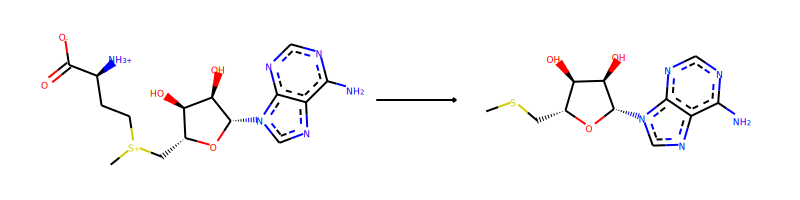

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '37472', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 46 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: O=P([O-])([O-])O[C@H:6]1[O:5][C@H:4]([CH2:3][S:2][CH3:1])[C@@H:14]([OH:15])[C@H:12]1[OH:13].[NH2:16][c:17]1[n:18][cH:19][n:20][c:21]2[nH:22][cH:23][n:24][c:25]12>>[CH3:1][S:2][CH2:3][C@H:4]1[O:5][C@@H:6]([n:22]2[c:21]3[n:20][cH:19][n:18][c:17]([NH2:16])[c:25]3[n:24][cH:23]2)[C@H:12]([OH:13])[C@@H:14]1[OH:15]
Reactant SMILES: O=P([O-])([O-])O[C@H:6]1[O:5][C@H:4]([CH2:3][S:2][CH3:1])[C@@H:14]([OH:15])[C@H:12]1[OH:13].[NH2:16][c:17]1[n:18][cH:19][n:20][c:21]2[nH:22][cH:23][n:24][

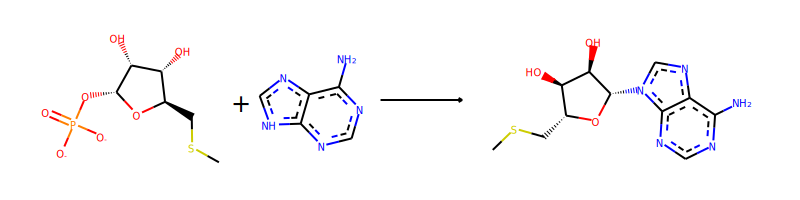

-> template: {'products': '[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3]', 'reactants': 'O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'reaction_smarts': '([#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[n;H0;D3;+0:9]:1-[C@H;D3;+0:1](-[#8:2])-[C:3])>>O=P(-[O-])(-[O-])-O-[C@@H;D3;+0:1](-[#8:2])-[C:3].[#7;a:4]:[c:5]1:[c:6]:[#7;a:7]:[c:8]:[nH;D2;+0:9]:1', 'intra_only': False, 'dimer_only': False, 'reaction_id': '11854', 'necessary_reagent': ''}
Precursor similarity 0.7391304347826086, overall 0.5057208237986269, smiles C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12


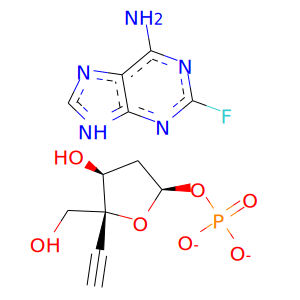



--------------------------------------------------

RANK 47 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])C(=O)[O-]>>[CH3:1][S:2][CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27]
Reactant SMILES: [NH3+][C@@H](CC[S+:2]([CH3:1])[CH2:10][C@H:11]1[O:12][C@@H:13]([n:14]2[cH:15][n:16][c:17]3[c:18]([NH2:19])[n:20][cH:21][n:22][c:23]23)[C@H:24]([OH:25])[C@@H:26]1[OH:27])C(=O)[O-]
RHEA ID: 14646
Original Reaction SMILES from RHEA: C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.[H]O[H]>>CSC[C@H]1O[C@@H](N2C=NC3=C2N=CN=C3N)[C@H](O)[C@@H]1O.[H+].[NH3+][C@@H](CCO)C(=O)[O-]


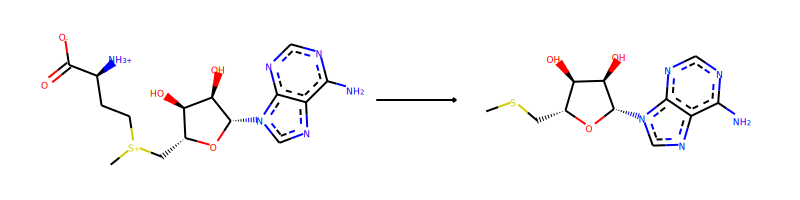

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '14646', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 48 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+][C@@H](CC[S+:29]([CH3:28])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54])C(=O)[O-]>>[CH3:28][S:29][CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c:50]23)[C@H:51]([OH:52])[C@@H:53]1[OH:54]
Reactant SMILES: [NH3+][C@@H](CC[S+:29]([CH3:28])[CH2:37][C@H:38]1[O:39][C@@H:40]([n:41]2[cH:42][n:43][c:44]3[c:45]([NH2:46])[n:47][cH:48][n:49][c

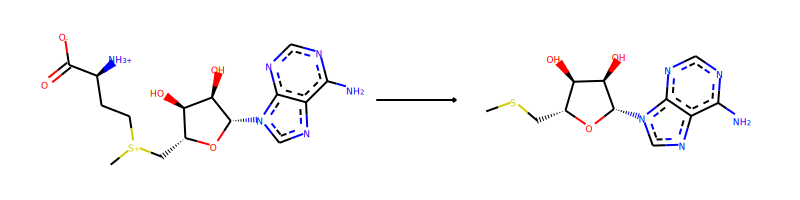

-> template: {'products': '[C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3]', 'reaction_smarts': '([C:2]-[S;H0;D2;+0:1]-[C;D1;H3:3])>>(O=C(-[O-])-[C@@H](-[NH3+])-C-C-[S+;H0;D3:1](-[C:2])-[C;D1;H3:3])', 'intra_only': True, 'dimer_only': False, 'reaction_id': 16482, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 49 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]>>[CH3:1][S:2][CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]
Reactant SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:2

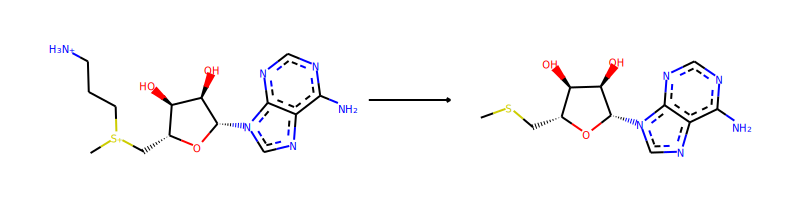

-> template: {'products': '[C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3]', 'reactants': '[C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+]', 'reaction_smarts': '([C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3])>>([C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '33388', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 50 PRECEDENT
PRODUCT MATCH SCORE: 0.6842105263157895
Reaction SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]>>[CH3:1][S:2][CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]
Reactant SMILES: [NH3+]CCC[S+:2]([CH3:1])[CH2:7][C@H:8]1[O:9][C@@H:10]([n:11]2[cH:12][n:13][c:14]3[c:15]([NH2:16])[n:17][cH:18][n:19][c:20]23)[C@H:21]([OH:22])[C@@H:23]1[OH:24]
RHEA ID: 44133
Original Reactio

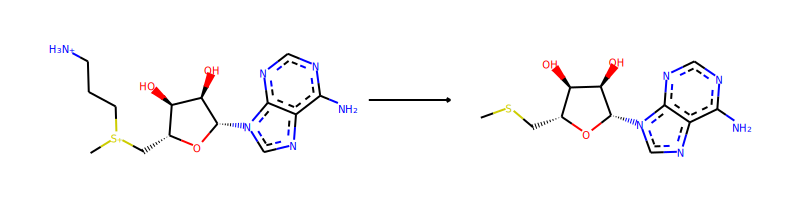

-> template: {'products': '[C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3]', 'reactants': '[C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+]', 'reaction_smarts': '([C:1]-[S;H0;D2;+0:2]-[C;D1;H3:3])>>([C:1]-[S+;H0;D3:2](-[C;D1;H3:3])-C-C-C-[NH3+])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '44133', 'necessary_reagent': ''}
No precursors could be generated!


(1,
 ['NC1=NC(F)=NC2=C1N=CN2[C@H]3C[C@H](O)[C@](CO)(C#C)O3'],
 [[1,
   'C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12',
   0.625784645098986],
  [2,
   'C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O',
   0.6235730793472932],
  [3,
   'C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O',
   0.6212929379133775],
  [4,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)[n+](C/C=C(\\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c(F)nc32)C[C@@H]1O',
   0.5977742448330684],
  [5,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(=O)[nH]c(F)nc32)C[C@@H]1O.[NH4+]',
   0.5970741383585421],
  [6,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]',
   0.5735011734585023],
  [7,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)[n+](C/C=C(\\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c32)C[C@@H]1O',
   0.5596184419713831],
  [8,
   'C#C[C@]1(C[S+](C)CC[C@H]([NH3+])C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O',
   0.5530950305143854],
  [9,
   'C#C[C@]1(CSCC[C@H]([NH3+])

In [36]:
do_one (0,draw =True)

In [37]:
do_one (0,debug =True)

Desired Product:
NC1=NC(F)=NC2=C1N=CN2[C@H]3C[C@H](O)[C@](CO)(C#C)O3
True reaction:
OC[C@@]1(C#C)O[C@H](OP([O-])([O-])=O)C[C@@H]1O.NC2=NC(F)=NC3=C2N=CN3>>NC4=NC(F)=NC5=C4N=CN5[C@H]6C[C@H](O)[C@](CO)(C#C)O6
prec_goal: C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12

Reaction precedent 1, prod similarity 0.7706422018348624
-> rxn_smiles [NH4+:1].O=[c:3]1[nH:4][cH:5][n:6][c:7]2[c:8]1[n:9][cH:10][n:11]2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][OH:18])[O:19]1>>[NH2:1][c:3]1[n:4][cH:5][n:6][c:7]2[c:8]1[n:9][cH:10][n:11]2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][OH:18])[O:19]1
-> RHEA ID 28192
-> Original Reaction From RHEA: O=C1NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](CO)O1.[H][N+]([H])([H])[H]>>NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC=N1.[H+].[H]O[H] 
-> template: ([#7;a:6]:[c:5]1:[#7;a:4]:[c:3]:[n;H0;D2;+0:2]:[c;H0;D3;+0:1](-[NH2;D1;+0:9]):[c:7]:1:[#7;a:8])>>O=[c;H0;D3;+0:1]1:[nH;D2;+0:2]:[c:3]:[#7;a:4]:[c:5](:[#7;a:6]):[c:7]:1:[#7;a:8].[NH4+;D0:9]
-

(1,
 ['NC1=NC(F)=NC2=C1N=CN2[C@H]3C[C@H](O)[C@](CO)(C#C)O3'],
 [[1,
   'C#C[C@]1(CO)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O.Nc1nc(F)nc2[nH]cnc12',
   0.625784645098986],
  [2,
   'C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O',
   0.6235730793472932],
  [3,
   'C#C[C@]1(COP(=O)([O-])[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O',
   0.6212929379133775],
  [4,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)[n+](C/C=C(\\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c(F)nc32)C[C@@H]1O',
   0.5977742448330684],
  [5,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(=O)[nH]c(F)nc32)C[C@@H]1O.[NH4+]',
   0.5970741383585421],
  [6,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1OP(=O)([O-])[O-]',
   0.5735011734585023],
  [7,
   'C#C[C@]1(CO)O[C@@H](n2cnc3c(N)nc(F)[n+](C/C=C(\\C)CC[C@]4(C)[C@@H](C)CC=C5[C@H]4CCCC5(C)C)c32)C[C@@H]1O',
   0.5596184419713831],
  [8,
   'C#C[C@]1(C[S+](C)CC[C@H]([NH3+])C(=O)[O-])O[C@@H](n2cnc3c(N)nc(F)nc32)C[C@@H]1O.O',
   0.5530950305143854],
  [9,
   'C#C[C@]1(CSCC[C@H]([NH3+])

## Step 2: Phosphopentomutase

In [47]:
found_rank = do_one (1)
return_statement = re_ranker (found_rank)
return_statement

(6,
 [[9,
   'C#C[C@]1(CO)OC(O)C[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O',
   0.5996156310057655,
   2.465736774357467,
   0.6851440269176781],
  [12,
   'C#C[C@]1(CO)OC(O)C[C@@H]1O.Cc1cc2nc3c(=O)[n-]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c2cc1C',
   0.5973451327433629,
   2.465736774357467,
   0.6851440269176781],
  [27,
   'C#C[C@]1(CO)OC(O)C[C@@H]1O.O=P([O-])([O-])O',
   0.45562500000000006,
   2.465736774357467,
   0.6851440269176781],
  [7,
   'C#C[C@]1(CO)O[C@H](O)C[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O',
   0.6243628950050969,
   2.5485176861301984,
   0.6023631151449469],
  [29,
   'C#C[C@]1(CO)O[C@H](O)C[C@@H]1O.O=P([O-])([O-])O',
   0.45562500000000006,
   2.5485176861301984,
   0.6023631151449469],
  [6,
   'C#C[C@]1(COP(=O)([O-])[O-])OC(O)C[C@@H]1O',
   0.6312629011071494,
   2.765557096123002,
   0.3853237051521434],
  [26,
   'C#C[C@]1(CO)O[C@H](O

## Step 3: Deoxyribose 5-Phosphate Aldolase

In [48]:
found_rank = do_one (2)
return_statement = re_ranker (found_rank)
return_statement

(1,
 [[7,
   'C#C[C@](O)(C=O)COP(=O)([O-])O.CC=O',
   0.431813535064404,
   2.172528062089565,
   0.7233742917614174],
  [19,
   'C#C[C@@](O)(COP(=O)([O-])O)[C@@H](O)CC=O',
   0.30684931506849317,
   2.535885960703198,
   0.36001639314778444],
  [20,
   'C#C[C@]1(COP(=O)([O-])O)OC(O)C[C@H]1O',
   0.30250000000000005,
   2.740168531229289,
   0.1557338226216931],
  [16,
   'C#C[C@]1(COP(=O)([O-])O)OC(=O)C[C@@H]1O',
   0.37869822485207105,
   3.0529311705006763,
   -0.15702881664969404],
  [17,
   'C#C[C@]1(COP(=O)([O-])O)OC([NH3+])C[C@@H]1O.O=P([O-])([O-])O',
   0.3654736842105264,
   3.0908094782115874,
   -0.1949071243606051],
  [18,
   'C#C[C@]1(COP(=O)([O-])O)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O',
   0.3654736842105264,
   3.3456901256573075,
   -0.44978777180632523],
  [14,
   'C#C[C@]1(COP(=O)([O-])O)O[C@H](OP(=O)([O-])OP(=O)([O-])[O-])C[C@@H]1O',
   0.399304347826087,
   3.4232479564218226,
   -0.5273456025708403],
  [11,
   'C#C[C@]1(COP(=O)([O-])O)O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)

['OC1C[C@H](O)[C@](COP([O-])(O)=O)(C#C)O1']
The desired molecule is:


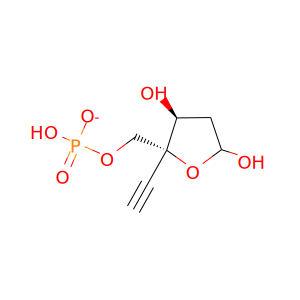

The desired reaction is:


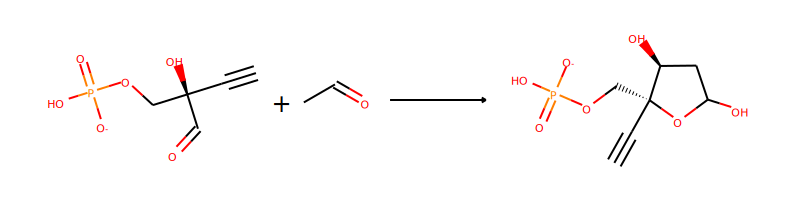



--------------------------------------------------

RANK 1 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: Nc1nc2c(ncn2[C@H:9]2[CH2:10][C@H:11]([OH:12])[C@@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[O:20]2)c(=O)[nH]1.[OH2:24]>>[CH:9]1([OH:24])[CH2:10][C@H:11]([OH:12])[C@@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[O:20]1
Reactant SMILES: Nc1nc2c(ncn2[C@H:9]2[CH2:10][C@H:11]([OH:12])[C@@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[O:20]2)c(=O)[nH]1.[OH2:24]
RHEA ID: 57817
Original Reaction SMILES from RHEA: NC1=NC2=C(N=CN2[C@H]2C[C@H](O)[C@@H](COP(=O)([O-])[O-])O2)C(=O)N1.[H]O[H]>>NC1=NC2=C(N=CN2)C(=O)N1.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O


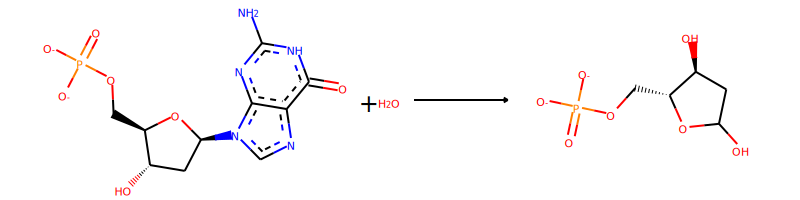

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:[nH]:c(=O):c2:n:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:2:n:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:[nH]:c(=O):c2:n:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:2:n:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '57817', 'necessary_reagent': ''}
Precursor similarity 0.8120300751879699, overall 0.5339375836852405, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)C[C@@H]1O.O


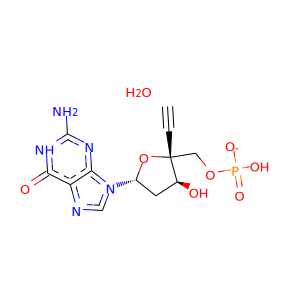



--------------------------------------------------

RANK 2 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: Cc1cn([C@H:5]2[CH2:6][C@H:7]([OH:8])[C@@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[O:16]2)c(=O)[nH]c1=O.[OH2:22]>>[CH:5]1([OH:22])[CH2:6][C@H:7]([OH:8])[C@@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[O:16]1
Reactant SMILES: Cc1cn([C@H:5]2[CH2:6][C@H:7]([OH:8])[C@@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[O:16]2)c(=O)[nH]c1=O.[OH2:22]
RHEA ID: 52713
Original Reaction SMILES from RHEA: CC1=CN([C@H]2C[C@H](O)[C@@H](COP(=O)([O-])[O-])O2)C(=O)NC1=O.[H]O[H]>>CC1=CNC(=O)NC1=O.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O


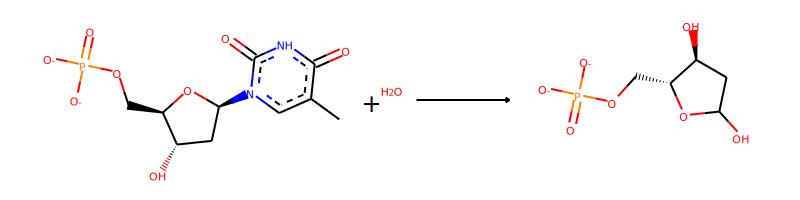

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'C-c1:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):[nH]:c:1=O.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>C-c1:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):[nH]:c:1=O.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '52713', 'necessary_reagent': ''}
Precursor similarity 0.7899159663865546, overall 0.5193967998158167, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cc(C)c(=O)[nH]c2=O)C[C@@H]1O.O


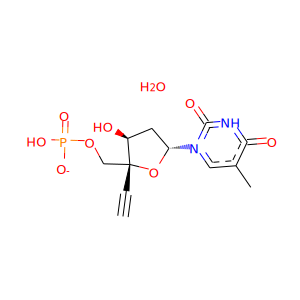



--------------------------------------------------

RANK 3 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@@H:6]1[CH2:7][C@H:8]([OH:9])[C@@H:10]([CH2:11][OH:12])[O:13]1>>[O:1]=[P:2]([O-:3])([O-:4])[O:12][CH2:11][C@@H:10]1[C@@H:8]([OH:9])[CH2:7][CH:6]([OH:5])[O:13]1
Reactant SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@@H:6]1[CH2:7][C@H:8]([OH:9])[C@@H:10]([CH2:11][OH:12])[O:13]1
RHEA ID: 27659
Original Reaction SMILES from RHEA: O=P([O-])([O-])O[C@@H]1C[C@H](O)[C@@H](CO)O1>>O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O


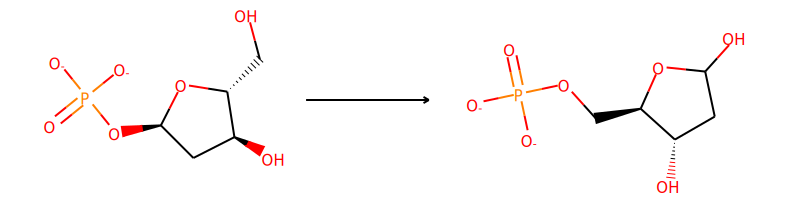

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8]', 'reactants': '[#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8])>>([#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '27659', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 4 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[OH:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[CH2:38][C@@H:39]1[OH:40]>>[P:20]

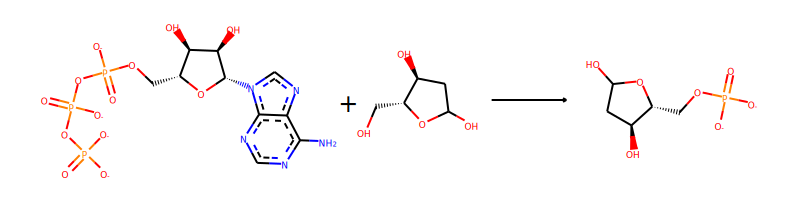

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '30872', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 5 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: [CH3:1][CH:2]=[O:3].[O:4]=[CH:5][C@H:6]([OH:7])[CH2:8][O:9][P:10](=[O:11])([O-:12])[O-:13]>>[CH2:1]1[CH:2]([OH:3])[O:7][C@H:6]([CH2:8][O:9][P:10](=[O:11])([O

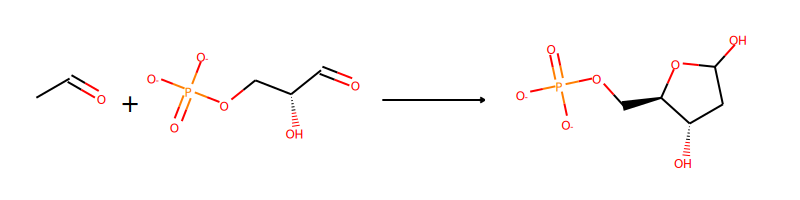

-> template: {'products': '[OH;D1;+0:3]-[CH;D3;+0:2]1-[CH2;D2;+0:1]-[C@H;D3;+0:5](-[OH;D1;+0:4])-[C:6]-[O;H0;D2;+0:7]-1', 'reactants': '[CH3;D1;+0:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3].[O;H0;D1;+0:4]=[CH;D2;+0:5]-[C:6]-[OH;D1;+0:7]', 'reaction_smarts': '([OH;D1;+0:3]-[CH;D3;+0:2]1-[CH2;D2;+0:1]-[C@H;D3;+0:5](-[OH;D1;+0:4])-[C:6]-[O;H0;D2;+0:7]-1)>>[CH3;D1;+0:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3].[O;H0;D1;+0:4]=[CH;D2;+0:5]-[C:6]-[OH;D1;+0:7]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '12823', 'necessary_reagent': ''}
Precursor similarity 0.6567164179104478, overall 0.431813535064404, smiles C#C[C@](O)(C=O)COP(=O)([O-])O.CC=O


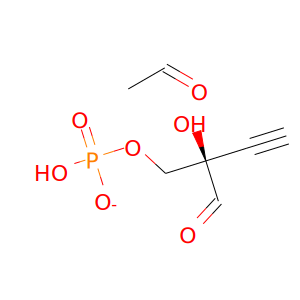



--------------------------------------------------

RANK 6 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: O=c1[nH]cnc2c1ncn2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][O:18][P:19](=[O:20])([O-:21])[O-:22])[O:23]1.[OH2:1]>>[OH:1][CH:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][O:18][P:19](=[O:20])([O-:21])[O-:22])[O:23]1
Reactant SMILES: O=c1[nH]cnc2c1ncn2[C@H:12]1[CH2:13][C@H:14]([OH:15])[C@@H:16]([CH2:17][O:18][P:19](=[O:20])([O-:21])[O-:22])[O:23]1.[OH2:1]
RHEA ID: 57829
Original Reaction SMILES from RHEA: O=C1NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H]O[H]>>O=C1NC=NC2=C1N/C=N\2.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O


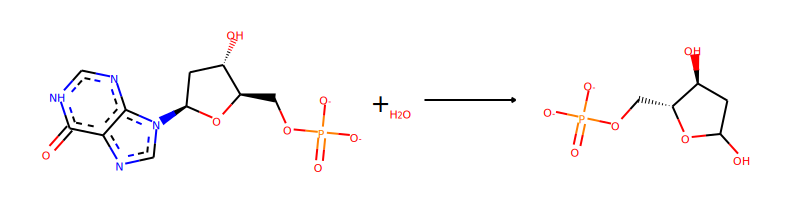

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'O=c1:[nH]:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>O=c1:[nH]:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '57829', 'necessary_reagent': ''}
Precursor similarity 0.8062015503875969, overall 0.5301051290219815, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]cnc32)C[C@@H]1O.O


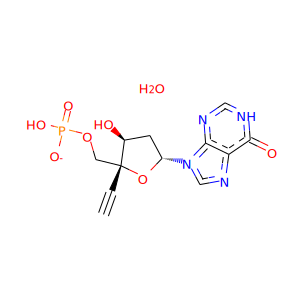



--------------------------------------------------

RANK 7 PRECEDENT
PRODUCT MATCH SCORE: 0.6575342465753424
Reaction SMILES: Nc1ncnc2c1ncn2[C@H:11]1[CH2:12][C@H:13]([OH:14])[C@@H:15]([CH2:16][O:17][P:18](=[O:19])([O-:20])[O-:21])[O:22]1.[OH2:23]>>[CH:11]1([OH:23])[CH2:12][C@H:13]([OH:14])[C@@H:15]([CH2:16][O:17][P:18](=[O:19])([O-:20])[O-:21])[O:22]1
Reactant SMILES: Nc1ncnc2c1ncn2[C@H:11]1[CH2:12][C@H:13]([OH:14])[C@@H:15]([CH2:16][O:17][P:18](=[O:19])([O-:20])[O-:21])[O:22]1.[OH2:23]
RHEA ID: 57825
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@H]1C[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H]O[H]>>NC1=C2N=CNC2=NC=N1.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O


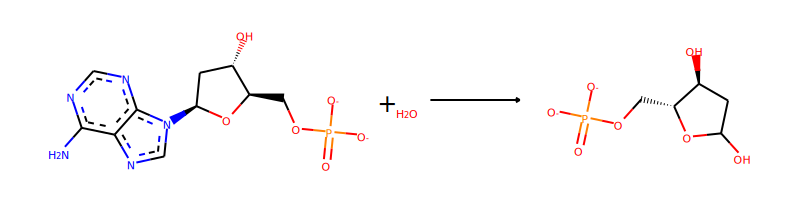

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '57825', 'necessary_reagent': ''}
Precursor similarity 0.8062015503875969, overall 0.5301051290219815, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(N)ncnc32)C[C@@H]1O.O


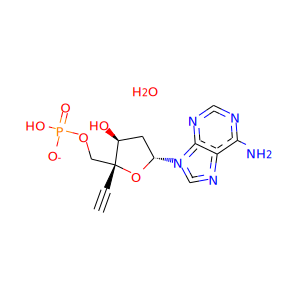



--------------------------------------------------

RANK 8 PRECEDENT
PRODUCT MATCH SCORE: 0.6153846153846154
Reaction SMILES: O[P:13](=[O:12])([O-:14])[O-:15].[OH:1][CH2:2][C@H:3]1[O:4][CH:5]([OH:6])[CH2:7][C@@H:8]([OH:9])[C@@H:10]1[OH:11]>>[O:1]([CH2:2][C@H:3]1[O:4][CH:5]([OH:6])[CH2:7][C@@H:8]([OH:9])[C@@H:10]1[OH:11])[P:13](=[O:12])([O-:14])[O-:15]
Reactant SMILES: O[P:13](=[O:12])([O-:14])[O-:15].[OH:1][CH2:2][C@H:3]1[O:4][CH:5]([OH:6])[CH2:7][C@@H:8]([OH:9])[C@@H:10]1[OH:11]
RHEA ID: 22238
Original Reaction SMILES from RHEA: O=P([O-])([O-])O.OC[C@H]1OC(O)C[C@@H](O)[C@@H]1O>>O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H](O)[C@@H]1O.[H]O[H]


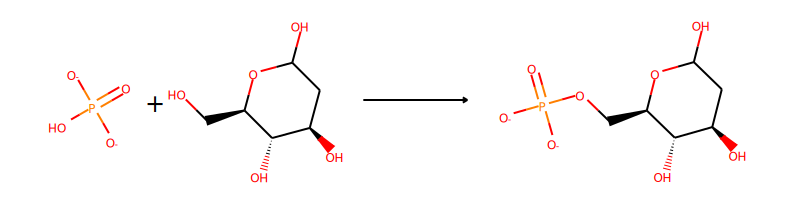

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4]', 'reactants': 'O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])>>O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '22238', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 9 PRECEDENT
PRODUCT MATCH SCORE: 0.6153846153846154
Reaction SMILES: [O:45]=[C:46]1[CH2:47][C@@H:48]([OH:49])[C@H:50]([OH:51])[C@@H:52]([CH2:53][O:54][P:55](=[O:56])([O-:57])[O-:58])[O:59]1>>[OH:45][CH:46]1[CH2:47][C@@H:48]([OH:49])[C@H:50]([OH:51])[C@@H:52]([CH2:53][O:54][P:55](=[O:56])([O-:57])[O-:58])[O:59]1
Reactant SMILES: [O:45]=[C:46]1[CH2:47][C@@H:48]([OH:49])[C@H:50]([OH:51])[C@@H:52]([CH2:53][O:54][P:55](=[O:56])

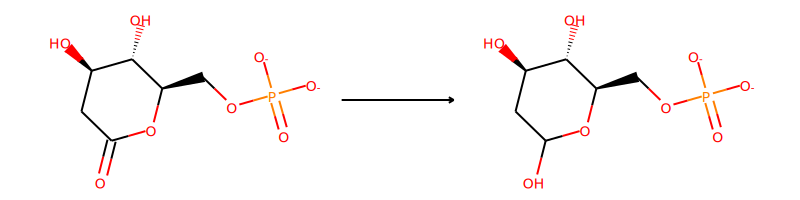

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4]', 'reactants': '[#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '62066', 'necessary_reagent': ''}
Precursor similarity 0.6153846153846154, overall 0.37869822485207105, smiles C#C[C@]1(COP(=O)([O-])O)OC(=O)C[C@@H]1O


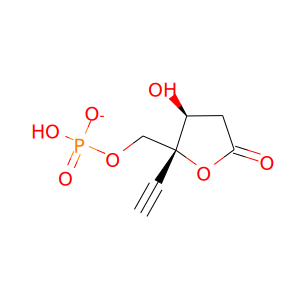



--------------------------------------------------

RANK 10 PRECEDENT
PRODUCT MATCH SCORE: 0.6153846153846154
Reaction SMILES: [O:49]=[C:50]1[CH2:51][C@@H:52]([OH:53])[C@H:54]([OH:55])[C@@H:56]([CH2:57][O:58][P:59](=[O:60])([O-:61])[O-:62])[O:63]1>>[OH:49][CH:50]1[CH2:51][C@@H:52]([OH:53])[C@H:54]([OH:55])[C@@H:56]([CH2:57][O:58][P:59](=[O:60])([O-:61])[O-:62])[O:63]1
Reactant SMILES: [O:49]=[C:50]1[CH2:51][C@@H:52]([OH:53])[C@H:54]([OH:55])[C@@H:56]([CH2:57][O:58][P:59](=[O:60])([O-:61])[O-:62])[O:63]1
RHEA ID: 62070
Original Reaction SMILES from RHEA: NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=C1C[C@@H](O)[C@H](O)[C@@H](COP(=O)([O-])[O-])O1.[H+]>>NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)=C1.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H](O)[C@@H]1O


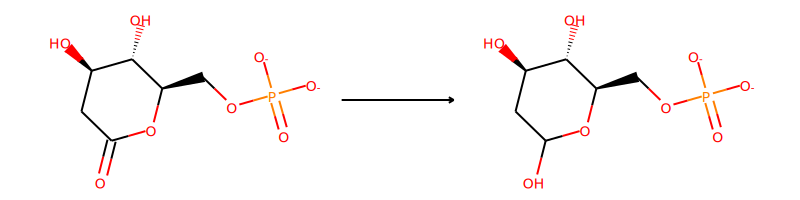

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4]', 'reactants': '[#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '62070', 'necessary_reagent': ''}
Precursor similarity 0.6153846153846154, overall 0.37869822485207105, smiles C#C[C@]1(COP(=O)([O-])O)OC(=O)C[C@@H]1O


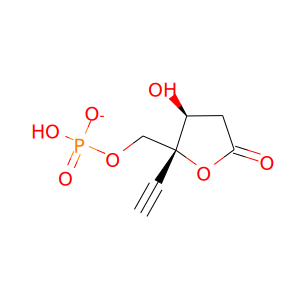



--------------------------------------------------

RANK 11 PRECEDENT
PRODUCT MATCH SCORE: 0.6153846153846154
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[OH:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[CH2:38][C@@H:39]([OH:40])[C@@H:41]1[OH:42]>>[P:20](=[O:21])([O-:22])([O-:23])[O:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[CH2:38][C@@H:39]([OH:40])[C@@H:41]1[OH:42]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[OH:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[CH2:38][C@@H:39]([OH:40])[C@@H:41]1[OH:42]
RHEA ID: 60565
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.OC[C@H]1OC(O)C[C@@H](O)[C@@H]1O>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H](O)[C@@H]1O.[H+]


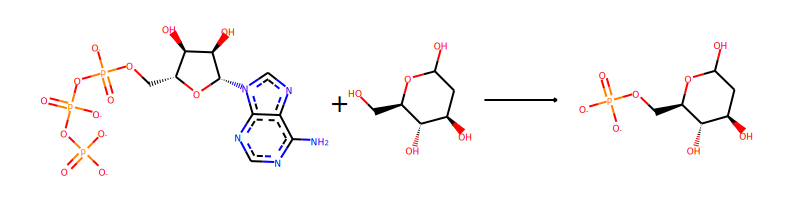

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '60565', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 12 PRECEDENT
PRODUCT MATCH SCORE: 0.5641025641025641
Reaction SMILES: [O:45]=[P:46]([O-:47])([O-:48])[O:49][CH2:50][C@H:51]1[O:52][CH:53]([OH:54])[CH2:55][C@@H:56]([OH:57])[C@@H:58]1[OH:59]>>[O:45]=[P:46]([O-:47])([O-:48])[O:4

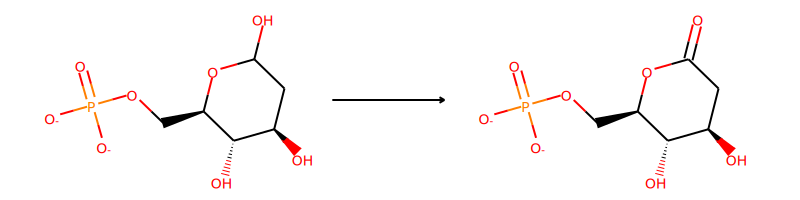

-> template: {'products': '[#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4]', 'reactants': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4]', 'reaction_smarts': '([#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])>>([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '62065', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 13 PRECEDENT
PRODUCT MATCH SCORE: 0.5641025641025641
Reaction SMILES: [O:49]=[P:50]([O-:51])([O-:52])[O:53][CH2:54][C@H:55]1[O:56][CH:57]([OH:58])[CH2:59][C@@H:60]([OH:61])[C@@H:62]1[OH:63]>>[O:49]=[P:50]([O-:51])([O-:52])[O:53][CH2:54][C@H:55]1[O:56][C:57](=[O:58])[CH2:59][C@@H:60]([OH:61])[C@@H:62]1[OH:63]
Reactant SMILES: [O:49]=[P:50]([O-:51])([O-:52])[O:53][CH2:54][C@H:55]1[O:56][CH:57]([OH:58])[CH2:59][C@@H:60]([OH:61])[C@@H:62]1[OH:63]
RHEA ID: 62069
Original Reaction SMILES from RHEA: NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4

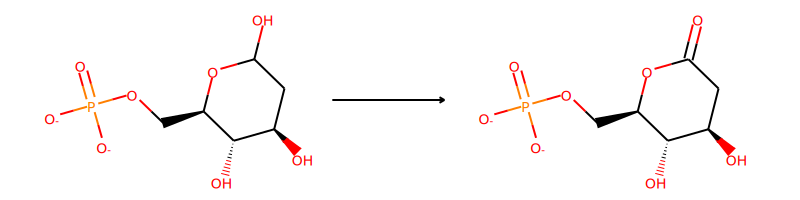

-> template: {'products': '[#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4]', 'reactants': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4]', 'reaction_smarts': '([#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])>>([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '62069', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 14 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ccn([C@@H]2O[C@H](COP(=O)([O-])O[P:15](=[O:16])([O-:17])[O:18][CH2:19][C@@H:20]([OH:21])[C@@H:22]([OH:23])[C@@H:24]([OH:25])[CH:26]=[O:27])[C@@H](O)[C@H]2O)c(=O)n1.O=P([O-])([O-])OP(=O)([O-])[OH:43]>>[P:15](=[O:16])([O-:17])([O:18][CH2:19][C@H:20]1[O:21][CH:26]([OH:27])[C@H:24]([OH:25])[C@@H:22]1[OH:23])[O-:43]
Reactant SMILES: Nc1ccn([C@@H]2O[C@H](COP(=O)([O-])O[P:15](=[O:16])([O-:17])[O:18][CH2:19][C@@H:20]([OH:21])[C@@H:22]([OH:23])[C@@H:24]([OH:25])[CH:26]=[O:27])[C@@H](O)[C@H]2O)c(=O)n1.O=P([O-])([O-])OP

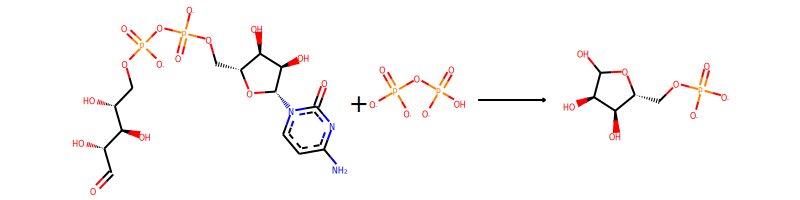

-> template: {'products': '[#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:10])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:8]-[O;H0;D2;+0:9]-[CH;D3;+0:6](-[C:5])-[OH;D1;+0:7]', 'reactants': 'N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].[C:8]-[OH;D1;+0:9].O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[OH;D1;+0:10]', 'reaction_smarts': '([#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:10])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:8]-[O;H0;D2;+0:9]-[CH;D3;+0:6](-[C:5])-[OH;D1;+0:7])>>N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].[C:8]-[OH;D1;+0:9].O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[OH;D1;+0:10]', 'intra_only': False, 'dimer_only': False, 'reaction_id': 53874, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 15 PRECEDENT
PRODUCT MATCH SCORE: 0.56
R

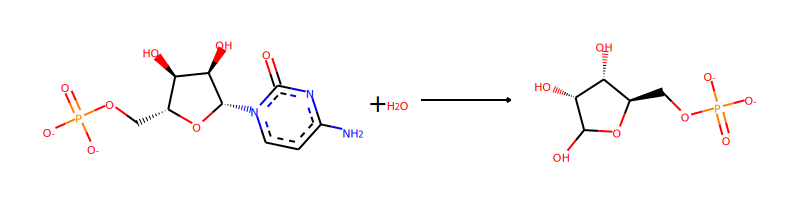

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:c:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):n:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:c:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):n:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '30076', 'necessary_reagent': ''}
Precursor similarity 0.717948717948718, overall 0.4020512820512821, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2ccc(N)nc2=O)C[C@@H]1O.O


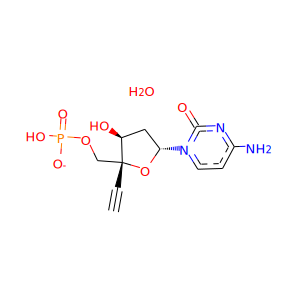



--------------------------------------------------

RANK 16 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: C/C(=C\CNc1ncnc2c1ncn2[C@@H:15]1[O:16][C@H:17]([CH2:18][O:19][P:20](=[O:21])([O-:22])[O-:23])[C@@H:24]([OH:25])[C@H:26]1[OH:27])CO.[OH2:30]>>[CH:15]1([OH:30])[O:16][C@H:17]([CH2:18][O:19][P:20](=[O:21])([O-:22])[O-:23])[C@@H:24]([OH:25])[C@H:26]1[OH:27]
Reactant SMILES: C/C(=C\CNc1ncnc2c1ncn2[C@@H:15]1[O:16][C@H:17]([CH2:18][O:19][P:20](=[O:21])([O-:22])[O-:23])[C@@H:24]([OH:25])[C@H:26]1[OH:27])CO.[OH2:30]
RHEA ID: 48565
Original Reaction SMILES from RHEA: C/C(=C\CNC1=C2N=CN([C@@H]3O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]3O)C2=NC=N1)CO.[H]O[H]>>C/C(=C\CNC1=C2N=CNC2=NC=N1)CO.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


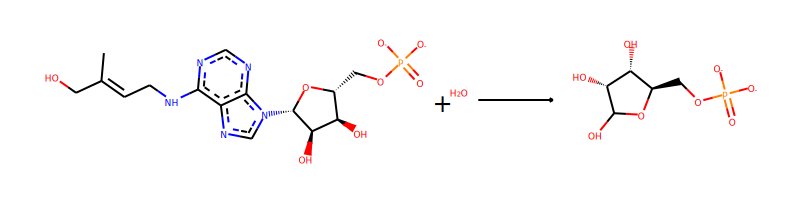

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'C/C(-C-O)=C\\C-N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>C/C(-C-O)=C\\C-N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '48565', 'necessary_reagent': ''}
Precursor similarity 0.8, overall 0.44800000000000006, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NC/C=C(\C)CO)ncnc32)C[C@@H]1O.O


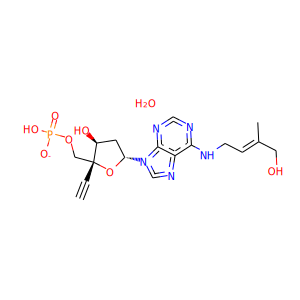



--------------------------------------------------

RANK 17 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: O=P([O-])([O-])OP(=O)([O-])[O:33][C@H:32]1[O:31][C@H:30]([CH2:29][O:28][P:25](=[O:24])([O-:26])[O-:27])[C@@H:44]([OH:45])[C@H:42]1[OH:43]>>[O:24]=[P:25]([O-:26])([O-:27])[O:28][CH2:29][C@H:30]1[O:31][CH:32]([OH:33])[C@H:42]([OH:43])[C@@H:44]1[OH:45]
Reactant SMILES: O=P([O-])([O-])OP(=O)([O-])[O:33][C@H:32]1[O:31][C@H:30]([CH2:29][O:28][P:25](=[O:24])([O-:26])[O-:27])[C@@H:44]([OH:45])[C@H:42]1[OH:43]
RHEA ID: 15611
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1O[C@H](OP(=O)([O-])OP(=O)([O-])[O-])[C@H](O)[C@@H]1O.[H+]>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


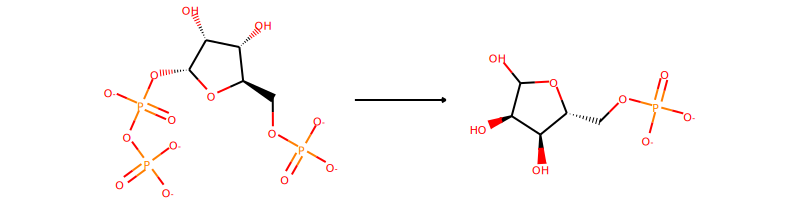

-> template: {'products': '[#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4]', 'reaction_smarts': '([#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '15611', 'necessary_reagent': ''}
Precursor similarity 0.7130434782608696, overall 0.399304347826087, smiles C#C[C@]1(COP(=O)([O-])O)O[C@H](OP(=O)([O-])OP(=O)([O-])[O-])C[C@@H]1O


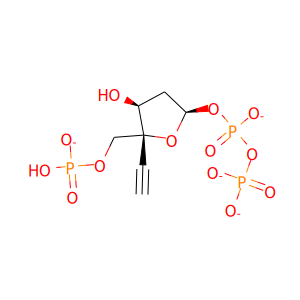



--------------------------------------------------

RANK 18 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: O=c1ccn([C@@H:7]2[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]2[OH:19])c(=O)[nH]1.[OH2:1]>>[OH:1][CH:7]1[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
Reactant SMILES: O=c1ccn([C@@H:7]2[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]2[OH:19])c(=O)[nH]1.[OH2:1]
RHEA ID: 52705
Original Reaction SMILES from RHEA: O=C1C=CN([C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)C(=O)N1.[H]O[H]>>O=C1C=CNC(=O)N1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


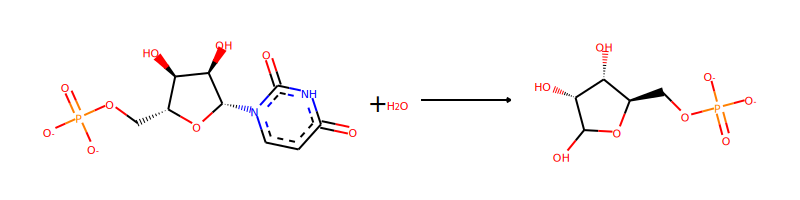

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'O=c1:[nH]:c(=O):n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:c:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>O=c1:[nH]:c(=O):n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:c:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '52705', 'necessary_reagent': ''}
Precursor similarity 0.717948717948718, overall 0.4020512820512821, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2ccc(=O)[nH]c2=O)C[C@@H]1O.O


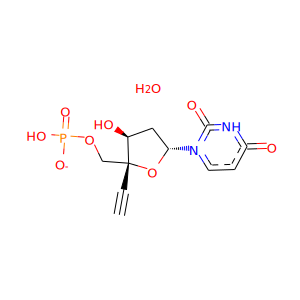



--------------------------------------------------

RANK 19 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: O=c1[nH]cc([C@@H:7]2[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]2[OH:19])c(=O)[nH]1.[OH2:1]>>[OH:1][CH:7]1[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]1[OH:19]
Reactant SMILES: O=c1[nH]cc([C@@H:7]2[O:8][C@H:9]([CH2:10][O:11][P:12](=[O:13])([O-:14])[O-:15])[C@@H:16]([OH:17])[C@H:18]2[OH:19])c(=O)[nH]1.[OH2:1]
RHEA ID: 18339
Original Reaction SMILES from RHEA: O=C1NC=C([C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)C(=O)N1.[H]O[H]>>O=C1C=CNC(=O)N1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


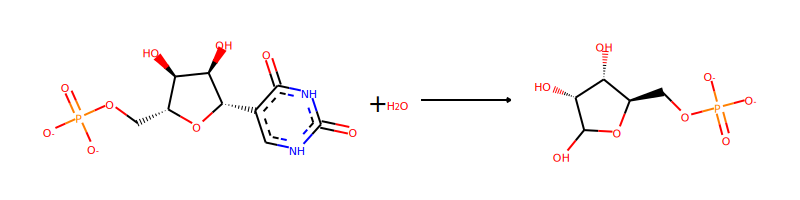

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'O=c1:[nH]:c:c(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):[nH]:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>O=c1:[nH]:c:c(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c(=O):[nH]:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '18339', 'necessary_reagent': ''}
Precursor similarity 0.6837606837606838, overall 0.38290598290598293, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](c2c[nH]c(=O)[nH]c2=O)C[C@@H]1O.O


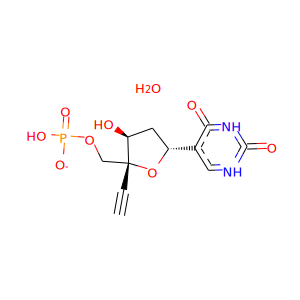



--------------------------------------------------

RANK 20 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.[OH2:37]>>[P:20](=[O:21])([O-:22])([O:23][CH2:24][C@H:25]1[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]1[OH:32])[O-:37]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.[OH2:37]
RHEA ID: 10413
Original Reaction SMILES from RHEA: NC1=C2/N=C\N([C@@H]3O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]4OC(O)[C@H](O)[C@@H]4O)[C@@H](O)[C@H]3O)C2=NC=N1.[H]O[H]>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+].[H+]


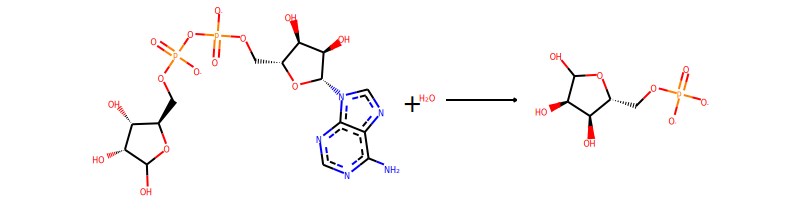

-> template: {'products': '[#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.[OH2;D0;+0:5]', 'reaction_smarts': '([#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.[OH2;D0;+0:5]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '10413', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 21 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1nc(O)c(N)c(N[C@@H:10]2[O:11][C@H:12]([CH2:13][O:14][P:15](=[O:16])([O-:17])[O-:18])[C@@H:19]([OH:20])[C@H:21]2[OH:22])n1.[OH2:24]>>[CH:10]1([OH:24])[O:11][C@H:12]([CH2:13][O:14][P:15](=[O:16])([O-:17])[O-:18])[C@@H:19]([OH:20])[C@H:21]1[OH:22]
Reactant SMIL

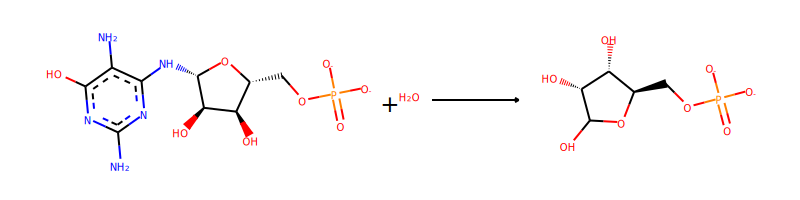

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:n:c(-O):c(-N):c(-N-[C@H;D3;+0:1](-[#8:2])-[C:3]):n:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:n:c(-O):c(-N):c(-N-[C@H;D3;+0:1](-[#8:2])-[C:3]):n:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '23437', 'necessary_reagent': ''}
Precursor similarity 0.7401574803149606, overall 0.414488188976378, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2nc(N)nc(O)c2N)C[C@@H]1O.O


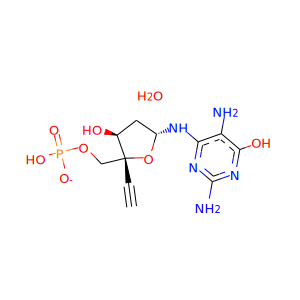



--------------------------------------------------

RANK 22 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: O=c1[nH]cnc2c1ncn2[C@@H:12]1[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([O-:19])[O-:20])[C@@H:21]([OH:22])[C@H:23]1[OH:24].[OH2:1]>>[OH:1][CH:12]1[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([O-:19])[O-:20])[C@@H:21]([OH:22])[C@H:23]1[OH:24]
Reactant SMILES: O=c1[nH]cnc2c1ncn2[C@@H:12]1[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([O-:19])[O-:20])[C@@H:21]([OH:22])[C@H:23]1[OH:24].[OH2:1]
RHEA ID: 20470
Original Reaction SMILES from RHEA: O=C1NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H]O[H]>>O=C1NC=NC2=C1N/C=N\2.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


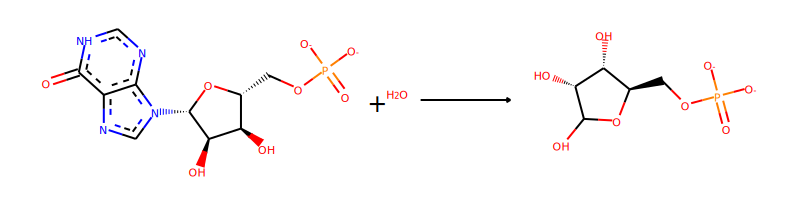

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'O=c1:[nH]:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>O=c1:[nH]:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '20470', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.4189312977099237, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]cnc32)C[C@@H]1O.O


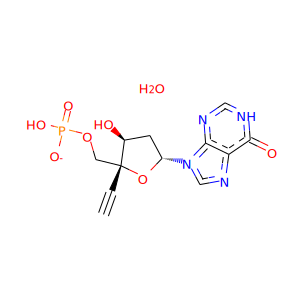



--------------------------------------------------

RANK 23 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: CC(C)=CCNc1ncnc2c1ncn2[C@@H:16]1[O:17][C@H:18]([CH2:19][O:20][P:21](=[O:22])([O-:23])[O-:24])[C@@H:25]([OH:26])[C@H:27]1[OH:28].[OH2:29]>>[CH:16]1([OH:29])[O:17][C@H:18]([CH2:19][O:20][P:21](=[O:22])([O-:23])[O-:24])[C@@H:25]([OH:26])[C@H:27]1[OH:28]
Reactant SMILES: CC(C)=CCNc1ncnc2c1ncn2[C@@H:16]1[O:17][C@H:18]([CH2:19][O:20][P:21](=[O:22])([O-:23])[O-:24])[C@@H:25]([OH:26])[C@H:27]1[OH:28].[OH2:29]
RHEA ID: 48561
Original Reaction SMILES from RHEA: CC(C)=CCNC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H]O[H]>>CC(C)=CCNC1=NC=NC2=C1N=CN2.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


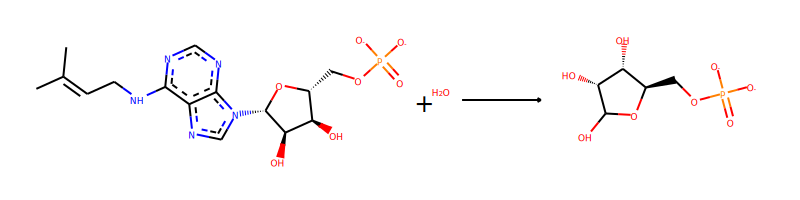

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'C-C(-C)=C-C-N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>C-C(-C)=C-C-N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '48561', 'necessary_reagent': ''}
Precursor similarity 0.7924528301886793, overall 0.44377358490566043, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NCC=C(C)C)ncnc32)C[C@@H]1O.O


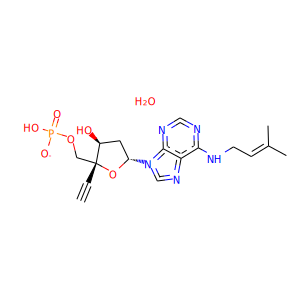



--------------------------------------------------

RANK 24 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: [O:1]=[CH:2][C@H:3]([OH:4])[C@H:5]([OH:6])[C@H:7]([OH:8])[CH2:9][O:10][P:11](=[O:12])([O-:13])[O-:14]>>[OH:1][CH:2]1[C@H:3]([OH:4])[C@H:5]([OH:6])[C@@H:7]([CH2:9][O:10][P:11](=[O:12])([O-:13])[O-:14])[O:8]1
Reactant SMILES: [O:1]=[CH:2][C@H:3]([OH:4])[C@H:5]([OH:6])[C@H:7]([OH:8])[CH2:9][O:10][P:11](=[O:12])([O-:13])[O-:14]
RHEA ID: 54529
Original Reaction SMILES from RHEA: O=C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-]>>O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


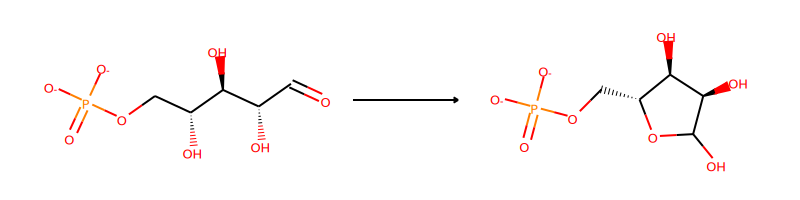

-> template: {'products': '[C:1]-[CH;D3;+0:2](-[OH;D1;+0:3])-[O;H0;D2;+0:5]-[C:4]', 'reactants': '[C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3].[C:4]-[OH;D1;+0:5]', 'reaction_smarts': '([C:1]-[CH;D3;+0:2](-[OH;D1;+0:3])-[O;H0;D2;+0:5]-[C:4])>>([C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3].[C:4]-[OH;D1;+0:5])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '54529', 'necessary_reagent': ''}
Precursor similarity 0.547945205479452, overall 0.30684931506849317, smiles C#C[C@@](O)(COP(=O)([O-])O)[C@@H](O)CC=O


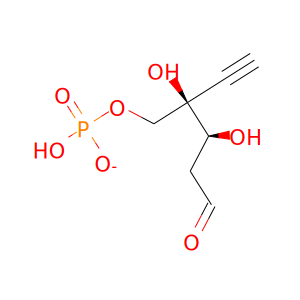



--------------------------------------------------

RANK 25 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ccn([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])[O:18][CH2:19][C@@H:20]([OH:21])[C@@H:22]([OH:23])[C@@H:24]([OH:25])[CH:26]=[O:27])[C@@H](O)[C@H]2O)c(=O)n1.O=P([O-])([O-])O[P:40](=[O:41])([O-:42])[OH:43]>>[O:18]([CH2:19][C@H:20]1[O:21][CH:26]([OH:27])[C@H:24]([OH:25])[C@@H:22]1[OH:23])[P:40](=[O:41])([O-:42])[O-:43]
Reactant SMILES: Nc1ccn([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])[O:18][CH2:19][C@@H:20]([OH:21])[C@@H:22]([OH:23])[C@@H:24]([OH:25])[CH:26]=[O:27])[C@@H](O)[C@H]2O)c(=O)n1.O=P([O-])([O-])O[P:40](=[O:41])([O-:42])[OH:43]
RHEA ID: 53874
Original Reaction SMILES from RHEA: O=P([O-])([O-])OP(=O)([O-])O.[H]C(=O)[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](N2C=CC(N)=NC2=O)[C@H](O)[C@@H]1O>>NC1=NC(=O)N([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]2O)C=C1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+]


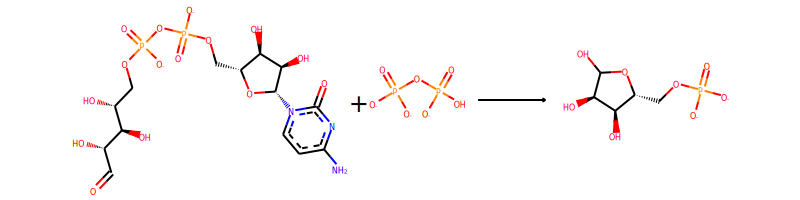

-> template: {'products': '[C:5]-[CH;D3;+0:6](-[OH;D1;+0:7])-[O;H0;D2;+0:4]-[C:3]-[C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:8](-[O-;H0;D1:11])(-[O;-;D1;H0:9])=[O;D1;H0:10]', 'reactants': 'N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2]-[C:3]-[OH;D1;+0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].O=P(-[O-])(-[O-])-O-[P;H0;D4;+0:8](-[O;-;D1;H0:9])(=[O;D1;H0:10])-[OH;D1;+0:11]', 'reaction_smarts': '([C:5]-[CH;D3;+0:6](-[OH;D1;+0:7])-[O;H0;D2;+0:4]-[C:3]-[C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:8](-[O-;H0;D1:11])(-[O;-;D1;H0:9])=[O;D1;H0:10])>>N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2]-[C:3]-[OH;D1;+0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].O=P(-[O-])(-[O-])-O-[P;H0;D4;+0:8](-[O;-;D1;H0:9])(=[O;D1;H0:10])-[OH;D1;+0:11]', 'intra_only': False, 'dimer_only': False, 'reaction_id': 53874, 'necessary_reagent': ''}
No precursors could be generated!


-------------------------------------

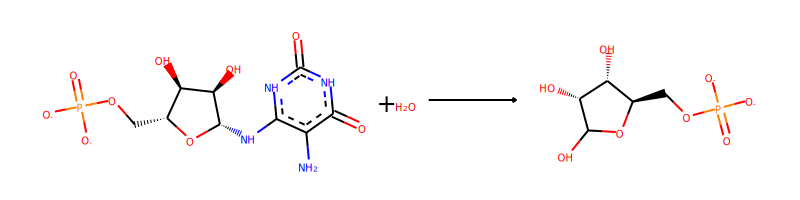

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:c(-N-[C@H;D3;+0:1](-[#8:2])-[C:3]):[nH]:c(=O):[nH]:c:1=O.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:c(-N-[C@H;D3;+0:1](-[#8:2])-[C:3]):[nH]:c(=O):[nH]:c:1=O.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '55021', 'necessary_reagent': ''}
Precursor similarity 0.7401574803149606, overall 0.414488188976378, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2[nH]c(=O)[nH]c(=O)c2N)C[C@@H]1O.O


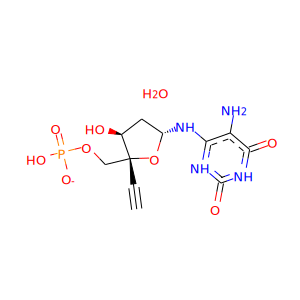



--------------------------------------------------

RANK 27 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: NC(=O)c1ccc[n+]([C@@H:9]2[O:10][C@H:11]([CH2:12][O:13][P:14](=[O:15])([O-:16])[O-:17])[C@@H:18]([OH:19])[C@H:20]2[OH:21])c1.[OH2:23]>>[CH:9]1([OH:23])[O:10][C@H:11]([CH2:12][O:13][P:14](=[O:15])([O-:16])[O-:17])[C@@H:18]([OH:19])[C@H:20]1[OH:21]
Reactant SMILES: NC(=O)c1ccc[n+]([C@@H:9]2[O:10][C@H:11]([CH2:12][O:13][P:14](=[O:15])([O-:16])[O-:17])[C@@H:18]([OH:19])[C@H:20]2[OH:21])c1.[OH2:23]
RHEA ID: 23141
Original Reaction SMILES from RHEA: NC(=O)C1=C[N+]([C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)=CC=C1.[H]O[H]>>NC(=O)C1=CC=CN=C1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+]


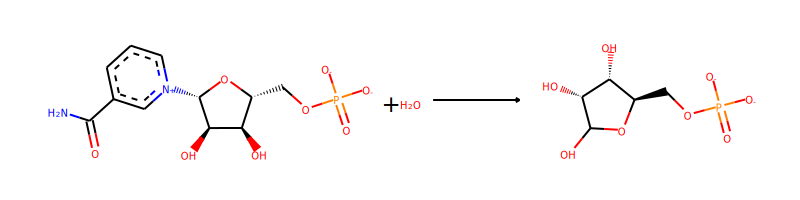

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-C(=O)-c1:c:c:c:[n+](-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-C(=O)-c1:c:c:c:[n+](-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '23141', 'necessary_reagent': ''}
Precursor similarity 0.7317073170731707, overall 0.40975609756097564, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H]([n+]2cccc(C(N)=O)c2)C[C@@H]1O.O


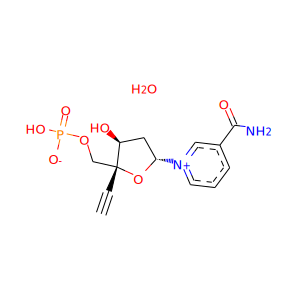



--------------------------------------------------

RANK 28 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H:11]1[O:12][C@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[C@@H:20]([OH:21])[C@H:22]1[OH:23].[OH2:24]>>[CH:11]1([OH:24])[O:12][C@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[C@@H:20]([OH:21])[C@H:22]1[OH:23]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H:11]1[O:12][C@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[C@@H:20]([OH:21])[C@H:22]1[OH:23].[OH2:24]
RHEA ID: 20130
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[H]O[H]>>NC1=C2N=CNC2=NC=N1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O


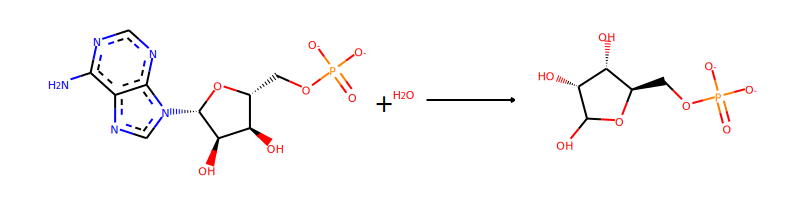

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@H;D3;+0:1](-[#8:2])-[C:3].[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '20130', 'necessary_reagent': ''}
Precursor similarity 0.7480916030534351, overall 0.4189312977099237, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(N)ncnc32)C[C@@H]1O.O


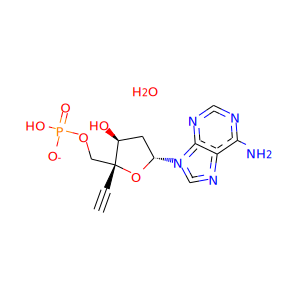



--------------------------------------------------

RANK 29 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O=P([O-])(O)[O-:40]>>[P:20](=[O:21])([O-:22])([O:23][CH2:24][C@H:25]1[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]1[OH:32])[O-:40]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O=P([O-])(O)[O-:40]
RHEA ID: 14531
Original Reaction SMILES from RHEA: NC1=C2/N=C\N([C@@H]3O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]4OC(O)[C@H](O)[C@@H]4O)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+]


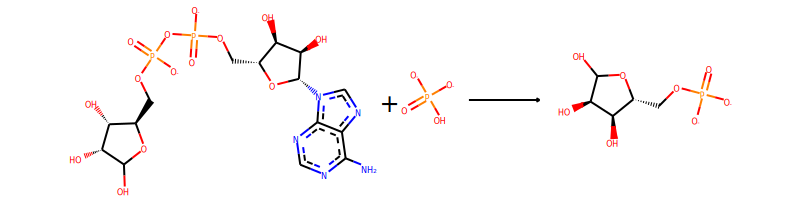

-> template: {'products': '[#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O-P(=O)(-[O-;H0;D1:5])-[O-]', 'reaction_smarts': '([#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O-P(=O)(-[O-;H0;D1:5])-[O-]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '14531', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 30 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1nc2c(ncn2[C@@H:9]2[O:10][C@H:11]([CH2:12][O:13][P:14](=[O:15])([O-:16])[O-:17])[C@@H:18]([OH:19])[C@H:20]2[OH:21])c(=O)[nH]1.[OH2:25]>>[CH:9]1([OH:25])[O:10][C@H:11]([CH2:12][O:13][P:14](=[O:15])([O-:16])[O-:17])[C@@H:18]([OH:19]

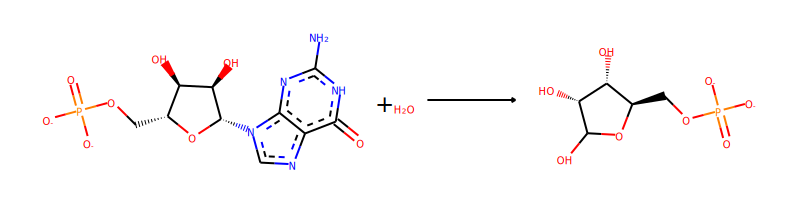

-> template: {'products': '[#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4]', 'reactants': 'N-c1:[nH]:c(=O):c2:n:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:2:n:1.[OH2;D0;+0:4]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:[nH]:c(=O):c2:n:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:2:n:1.[OH2;D0;+0:4]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '52709', 'necessary_reagent': ''}
Precursor similarity 0.7555555555555555, overall 0.42311111111111116, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)C[C@@H]1O.O


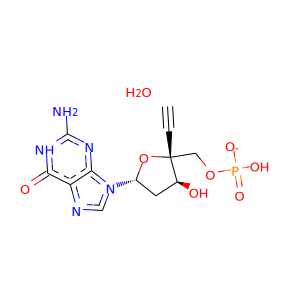



--------------------------------------------------

RANK 31 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O[P:38](=[O:37])([O-:39])[O-:40]>>[O:23]([CH2:24][C@H:25]1[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]1[OH:32])[P:38](=[O:37])([O-:39])[O-:40]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O[P:38](=[O:37])([O-:39])[O-:40]
RHEA ID: 14531
Original Reaction SMILES from RHEA: NC1=C2/N=C\N([C@@H]3O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]4OC(O)[C@H](O)[C@@H]4O)[C@@H](O)[C@H]3O)C2=NC=N1.O=P([O-])([O-])O>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+]


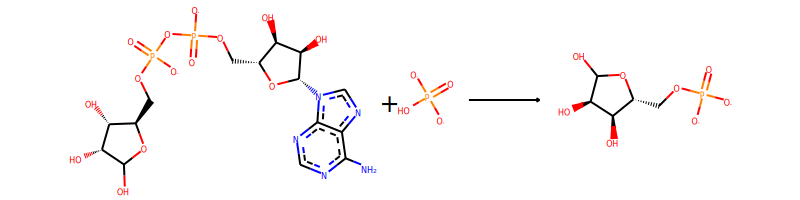

-> template: {'products': '[C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(-[O;-;D1;H0:5])=[O;D1;H0:6]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2])-[C@@H](-O)-[C@H]-1-O.O-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(-[O;-;D1;H0:5])=[O;D1;H0:6]', 'reaction_smarts': '([C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(-[O;-;D1;H0:5])=[O;D1;H0:6])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2])-[C@@H](-O)-[C@H]-1-O.O-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(-[O;-;D1;H0:5])=[O;D1;H0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '14531', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 32 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: [NH3+][CH:29]1[O:30][C@H:31]([CH2:32][O:33][P:34](=[O:35])([O-:36])[O-:37])[C@@H:38]([OH:39])[C@H:40]1[OH:41].O=P([O-])([O-])[OH:46]>>[CH:29]1([OH:46])[O:30][C@H:31]([CH2:3

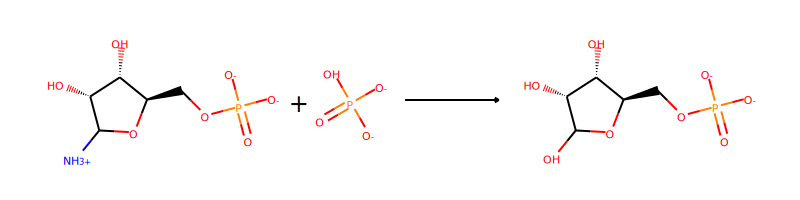

-> template: {'products': '[#8:2]-[CH;D3;+0:3](-[C:4])-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[OH;D1;+0:1].[#8:2]-[CH;D3;+0:3](-[C:4])-[NH3+]', 'reaction_smarts': '([#8:2]-[CH;D3;+0:3](-[C:4])-[OH;D1;+0:1])>>O=P(-[O-])(-[O-])-[OH;D1;+0:1].[#8:2]-[CH;D3;+0:3](-[C:4])-[NH3+]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '13779', 'necessary_reagent': ''}
Precursor similarity 0.6526315789473685, overall 0.3654736842105264, smiles C#C[C@]1(COP(=O)([O-])O)OC([NH3+])C[C@@H]1O.O=P([O-])([O-])O


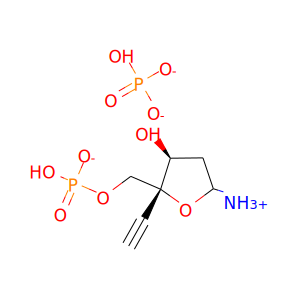



--------------------------------------------------

RANK 33 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[OH:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[C@H:38]([OH:39])[C@@H:40]1[OH:41]>>[P:20](=[O:21])([O-:22])([O-:23])[O:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[C@H:38]([OH:39])[C@@H:40]1[OH:41]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[OH:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[C@H:38]([OH:39])[C@@H:40]1[OH:41]
RHEA ID: 13698
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.OC[C@H]1OC(O)[C@H](O)[C@@H]1O>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H]1O.[H+]


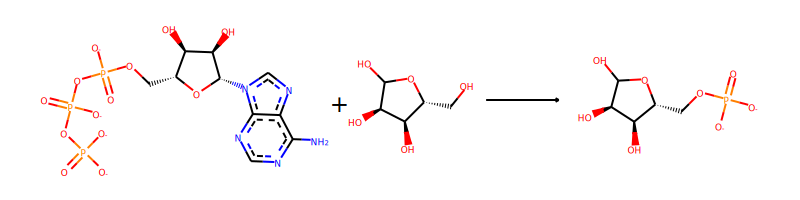

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '13698', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 34 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O=P([O-

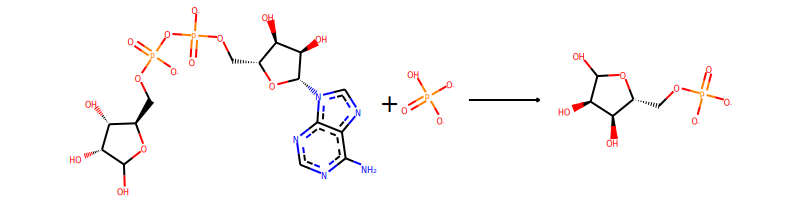

-> template: {'products': '[#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O=P(-[O-])(-[O-])-[OH;D1;+0:5]', 'reaction_smarts': '([#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:5])(-[O;-;D1;H0:3])=[O;D1;H0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O=P(-[O-])(-[O-])-[OH;D1;+0:5]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '14531', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 35 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: O[P:12](=[O:11])([O-:13])[O-:14].[OH:1][CH2:2][C@H:3]1[O:4][CH:5]([OH:6])[C@H:7]([OH:8])[C@@H:9]1[OH:10]>>[O:1]([CH2:2][C@H:3]1[O:4][CH:5]([OH:6])[C@H:7]([OH:8])[C@@H:9]1[OH:10])[P:12](=[O:11])([O-:13])[O-:14]
Reactant SMILES:

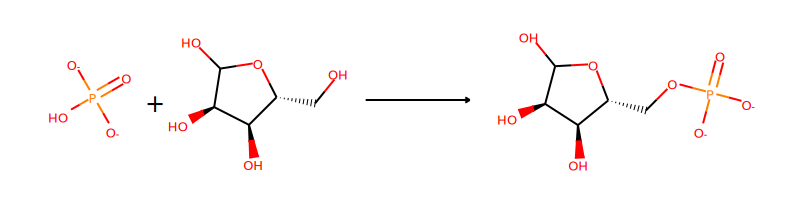

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4]', 'reactants': 'O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])>>O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '29473', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 36 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@H:6]1[O:7][C@H:8]([CH2:9][OH:10])[C@@H:11]([OH:12])[C@H:13]1[OH:14]>>[O:1]=[P:2]([O-:3])([O-:4])[O:10][CH2:9][C@H:8]1[O:7][CH:6]([OH:5])[C@H:13]([OH:14])[C@@H:11]1[OH:12]
Reactant SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@H:6]1[O:7][C@H:8]([CH2:9][OH:10])[C@@H:11]([OH:12])[C@H:13]1[OH:14]
RHEA ID: 18794
Original Reaction SMILES from

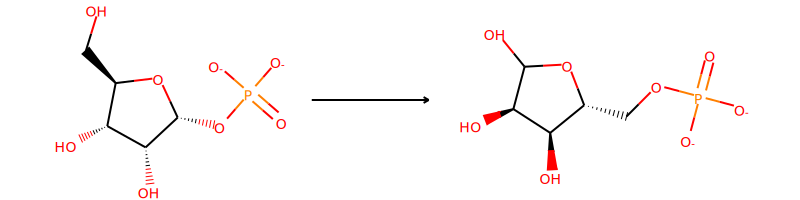

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8]', 'reactants': '[#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8])>>([#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '18794', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 37 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.[O-][P:38](=[O:37])([O-:39])[OH:41]>>[O:23]([CH

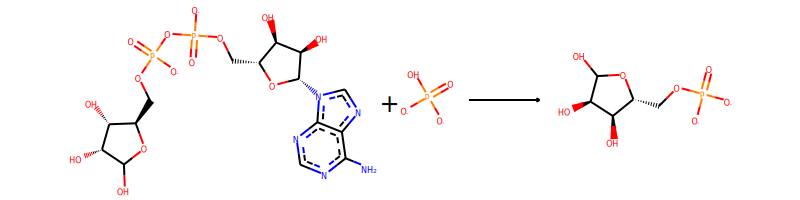

-> template: {'products': '[C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:3](-[O-;H0;D1:6])(-[O;-;D1;H0:4])=[O;D1;H0:5]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2])-[C@@H](-O)-[C@H]-1-O.[O-]-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(=[O;D1;H0:5])-[OH;D1;+0:6]', 'reaction_smarts': '([C:2]-[O;H0;D2;+0:1]-[P;H0;D4;+0:3](-[O-;H0;D1:6])(-[O;-;D1;H0:4])=[O;D1;H0:5])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[C:2])-[C@@H](-O)-[C@H]-1-O.[O-]-[P;H0;D4;+0:3](-[O;-;D1;H0:4])(=[O;D1;H0:5])-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '14531', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 38 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])[O:19][P:20]([O-])(=[O:21])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O=P([

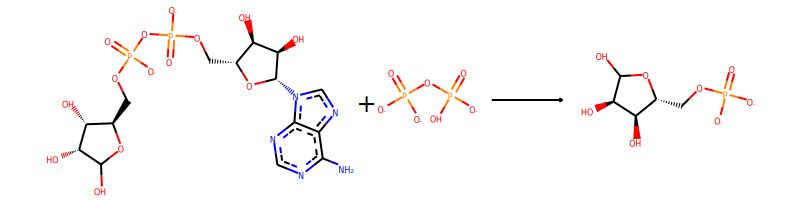

-> template: {'products': '[#8:3]-[P;H0;D4;+0:2](-[O-;H0;D1:1])(-[O-;H0;D1:5])=[O;D1;H0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[P;H0;D4;+0:2](-[#8:3])(-[O-])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O-P(=O)(-[O-;H0;D1:5])-O-P(=O)(-[O-])-[O-]', 'reaction_smarts': '([#8:3]-[P;H0;D4;+0:2](-[O-;H0;D1:1])(-[O-;H0;D1:5])=[O;D1;H0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[P;H0;D4;+0:2](-[#8:3])(-[O-])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O-P(=O)(-[O-;H0;D1:5])-O-P(=O)(-[O-])-[O-]', 'intra_only': False, 'dimer_only': False, 'reaction_id': 50250, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 39 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P:16](=[O:17])([O-:18])[O:19]P(=O)([O-])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O>>[P:16](=[O:17])([O-:18])([O-:

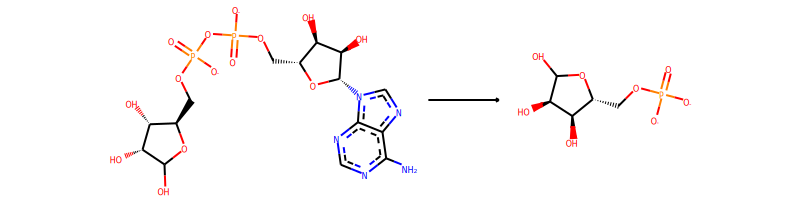

-> template: {'products': '[C:6]-[O;H0;D2;+0:5]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O;H0;D2;+0:5]-[C:6])-[C@@H](-O)-[C@H]-1-O', 'reaction_smarts': '([C:6]-[O;H0;D2;+0:5]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3])>>(N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O;H0;D2;+0:5]-[C:6])-[C@@H](-O)-[C@H]-1-O)', 'intra_only': True, 'dimer_only': False, 'reaction_id': 50250, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 40 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])[O:19][P:20]([O-])(=[O:21])[O:23][CH2:24][C@H:25]2[O:26][CH:27]([OH:28])[C@H:29]([OH:30])[C@@H:31]2[OH:32])[C@@H](O)[C@H]1O.O=P([O-])([O-])OP(=O)([O-])[OH:45]>>[O-:19

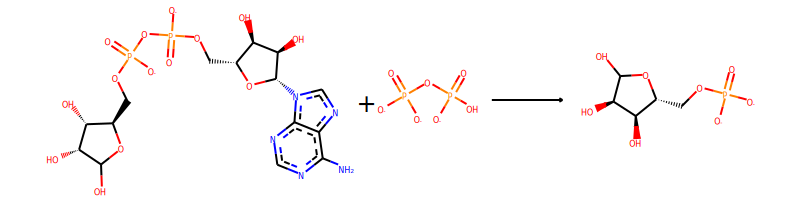

-> template: {'products': '[#8:3]-[P;H0;D4;+0:2](-[O-;H0;D1:1])(-[O-;H0;D1:5])=[O;D1;H0:4]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[P;H0;D4;+0:2](-[#8:3])(-[O-])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[OH;D1;+0:5]', 'reaction_smarts': '([#8:3]-[P;H0;D4;+0:2](-[O-;H0;D1:1])(-[O-;H0;D1:5])=[O;D1;H0:4])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-[O;H0;D2;+0:1]-[P;H0;D4;+0:2](-[#8:3])(-[O-])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-1-O.O=P(-[O-])(-[O-])-O-P(=O)(-[O-])-[OH;D1;+0:5]', 'intra_only': False, 'dimer_only': False, 'reaction_id': 50250, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 41 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reaction SMILES: Nc1ccn([C@@H]2O[C@H](COP(=O)([O-])O[P:15](=[O:16])([O-:17])[O:18][CH2:19][C@@H:20]([OH:21])[C@@H:22]([OH:23])[C@@H:24]([OH:25])[CH:26]=[O:27])[C@@H](O)[C@H]2O)c(=O)n1.O=P([O-])([O-])OP(=O)(O)[

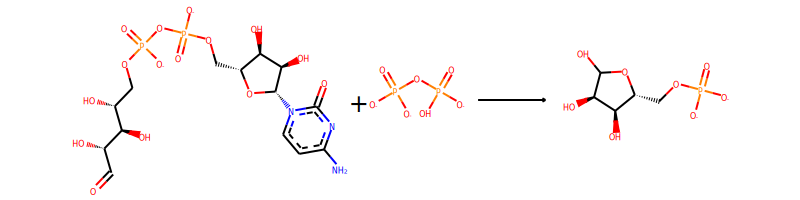

-> template: {'products': '[#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:10])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:8]-[O;H0;D2;+0:9]-[CH;D3;+0:6](-[C:5])-[OH;D1;+0:7]', 'reactants': 'N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].[C:8]-[OH;D1;+0:9].O-P(=O)(-[O-;H0;D1:10])-O-P(=O)(-[O-])-[O-]', 'reaction_smarts': '([#8:2]-[P;H0;D4;+0:1](-[O-;H0;D1:10])(-[O;-;D1;H0:3])=[O;D1;H0:4].[C:8]-[O;H0;D2;+0:9]-[CH;D3;+0:6](-[C:5])-[OH;D1;+0:7])>>N-c1:c:c:n(-[C@@H]2-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[#8:2])(-[O;-;D1;H0:3])=[O;D1;H0:4])-[C@@H](-O)-[C@H]-2-O):c(=O):n:1.[C:5]-[CH;D2;+0:6]=[O;H0;D1;+0:7].[C:8]-[OH;D1;+0:9].O-P(=O)(-[O-;H0;D1:10])-O-P(=O)(-[O-])-[O-]', 'intra_only': False, 'dimer_only': False, 'reaction_id': 53874, 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 42 PRECEDENT
PRODUCT MATCH SCORE: 0.56
Reactio

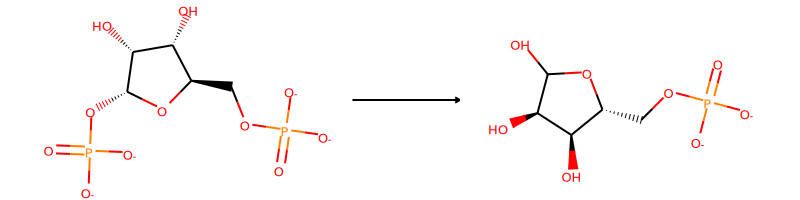

-> template: {'products': '[#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1]', 'reactants': 'O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4]', 'reaction_smarts': '([#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1])>>(O=P(-[O-])(-[O-])-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '21218', 'necessary_reagent': ''}
Precursor similarity 0.6526315789473685, overall 0.3654736842105264, smiles C#C[C@]1(COP(=O)([O-])O)O[C@H](OP(=O)([O-])[O-])C[C@@H]1O


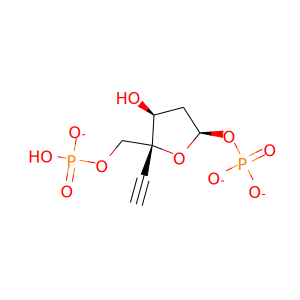



--------------------------------------------------

RANK 43 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: OC[C@H]1O[C@H]([O:15][C@H:14]2[O:13][C@H:12]([CH2:11][O:10][P:7](=[O:6])([O-:8])[O-:9])[C@@H:31]([OH:32])[C@H:29]([OH:30])[C@H:27]2[OH:28])[C@H](O)[C@@H](O)[C@@H]1O>>[O:6]=[P:7]([O-:8])([O-:9])[O:10][CH2:11][C@H:12]1[O:13][CH:14]([OH:15])[C@H:27]([OH:28])[C@@H:29]([OH:30])[C@@H:31]1[OH:32]
Reactant SMILES: OC[C@H]1O[C@H]([O:15][C@H:14]2[O:13][C@H:12]([CH2:11][O:10][P:7](=[O:6])([O-:8])[O-:9])[C@@H:31]([OH:32])[C@H:29]([OH:30])[C@H:27]2[OH:28])[C@H](O)[C@@H](O)[C@@H]1O
RHEA ID: 20865
Original Reaction SMILES from RHEA: O=P([O-])([O-])O.O=P([O-])([O-])OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O>>O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O.O=P([O-])([O-])O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O


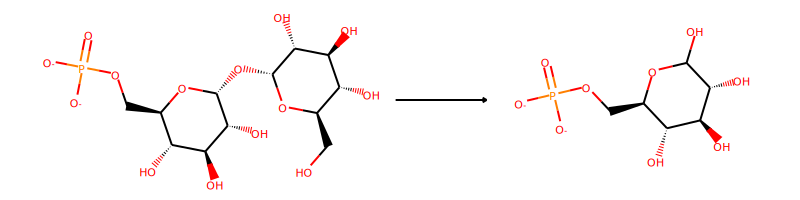

-> template: {'products': '[#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1]', 'reactants': 'O-C-[C@H]1-O-[C@H](-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])-[C@H](-O)-[C@@H](-O)-[C@@H]-1-O', 'reaction_smarts': '([#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1])>>(O-C-[C@H]1-O-[C@H](-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])-[C@H](-O)-[C@@H](-O)-[C@@H]-1-O)', 'intra_only': True, 'dimer_only': False, 'reaction_id': '20865', 'necessary_reagent': ''}
Precursor similarity 0.7428571428571429, overall 0.40857142857142864, smiles C#C[C@]1(COP(=O)([O-])O)O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)C[C@@H]1O


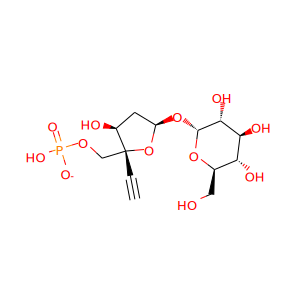



--------------------------------------------------

RANK 44 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@H:6]1[O:7][C@H:8]([CH2:9][OH:10])[C@@H:11]([OH:12])[C@H:13]([OH:14])[C@@H:15]1[OH:16]>>[O:1]=[P:2]([O-:3])([O-:4])[O:10][CH2:9][C@H:8]1[O:7][CH:6]([OH:5])[C@@H:15]([OH:16])[C@@H:13]([OH:14])[C@@H:11]1[OH:12]
Reactant SMILES: [O:1]=[P:2]([O-:3])([O-:4])[O:5][C@H:6]1[O:7][C@H:8]([CH2:9][OH:10])[C@@H:11]([OH:12])[C@H:13]([OH:14])[C@@H:15]1[OH:16]
RHEA ID: 11141
Original Reaction SMILES from RHEA: O=P([O-])([O-])O[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O>>O=P([O-])([O-])OC[C@H]1OC(O)[C@@H](O)[C@@H](O)[C@@H]1O


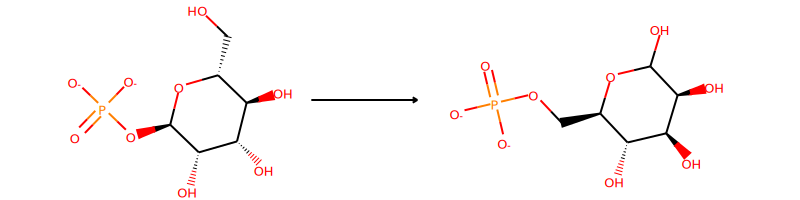

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8]', 'reactants': '[#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4].[C:9]-[O;H0;D2;+0:10]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8])>>([#8:1]-[C@@H;D3;+0:2](-[C:3])-[O;H0;D2;+0:4]-[P;H0;D4;+0:5](-[O;-;D1;H0:6])(-[O;-;D1;H0:7])=[O;D1;H0:8].[C:9]-[OH;D1;+0:10])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '11141', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 45 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: [NH3+][C@@H](CCCC[NH2+][CH2:8][C:9](=[O:10])[C@@H:11]([OH:12])[C@H:13]([OH:14])[C@H:15]([OH:16])[CH2:17][O:18][P:19](=[O:20])([O-:21])[O-:22])C(=O)[O-].[OH2:26]>>[CH:8]1([OH:26])[C@H:9]([OH:10])[C@

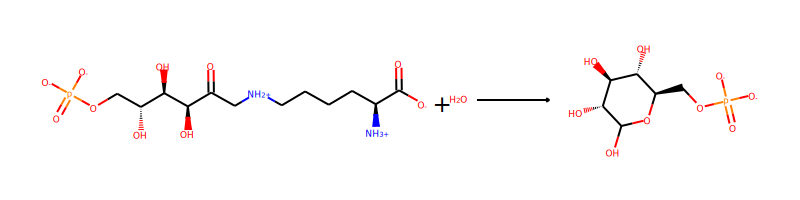

-> template: {'products': '[C:3]-[C@@H;D3;+0:2](-[OH;D1;+0:4])-[CH;D3;+0:1](-[OH;D1;+0:7])-[O;H0;D2;+0:6]-[C:5]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-C-C-[NH2+]-[CH2;D2;+0:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4].[C:5]-[OH;D1;+0:6].[OH2;D0;+0:7]', 'reaction_smarts': '([C:3]-[C@@H;D3;+0:2](-[OH;D1;+0:4])-[CH;D3;+0:1](-[OH;D1;+0:7])-[O;H0;D2;+0:6]-[C:5])>>O=C(-[O-])-[C@@H](-[NH3+])-C-C-C-C-[NH2+]-[CH2;D2;+0:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4].[C:5]-[OH;D1;+0:6].[OH2;D0;+0:7]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '28383', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 46 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: [NH3+][C@@H](CCCC[NH2+][CH2:8][C:9](=[O:10])[C@@H:11]([OH:12])[C@H:13]([OH:14])[C@H:15]([OH:16])[CH2:17][O:18][P:19](=[O:20])([O-:21])[O-:22])C(=O)[O-].[OH2:26]>>[CH:8]1([OH:10])[C@H:9]([OH:26])[C@@H:11]([OH:12])[C@H:13]([OH:14])[C@@H:15]([CH2:17][O:18][P:19](=[O:20

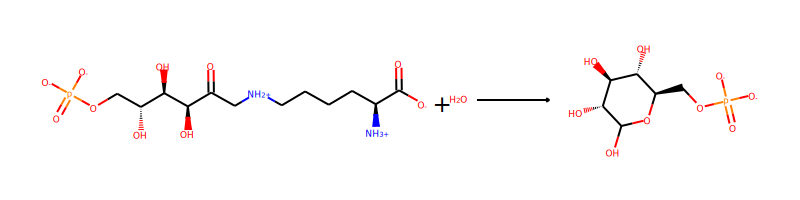

-> template: {'products': '[C:3]-[C@@H;D3;+0:2](-[OH;D1;+0:7])-[CH;D3;+0:1](-[OH;D1;+0:4])-[O;H0;D2;+0:6]-[C:5]', 'reactants': 'O=C(-[O-])-[C@@H](-[NH3+])-C-C-C-C-[NH2+]-[CH2;D2;+0:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4].[C:5]-[OH;D1;+0:6].[OH2;D0;+0:7]', 'reaction_smarts': '([C:3]-[C@@H;D3;+0:2](-[OH;D1;+0:7])-[CH;D3;+0:1](-[OH;D1;+0:4])-[O;H0;D2;+0:6]-[C:5])>>O=C(-[O-])-[C@@H](-[NH3+])-C-C-C-C-[NH2+]-[CH2;D2;+0:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4].[C:5]-[OH;D1;+0:6].[OH2;D0;+0:7]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '28383', 'necessary_reagent': ''}
No precursors could be generated!


--------------------------------------------------

RANK 47 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: [NH3+:1][C@H:2]1[CH:3]([OH:4])[O:5][C@H:6]([CH2:7][O:8][P:9](=[O:10])([O-:11])[O-:12])[C@H:13]([OH:14])[C@@H:15]1[OH:16]>>[NH3+:1][C@H:2]1[CH:3]([OH:4])[O:5][C@H:6]([CH2:7][O:8][P:9](=[O:10])([O-:11])[O-:12])[C@@H:13]([OH:14])[C@@H:15]1[OH:16]
Reactant SMILES: [NH3+

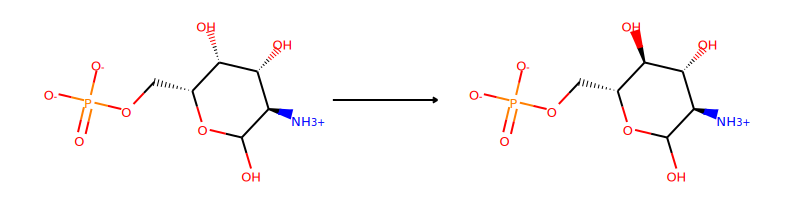

-> template: {'products': '[#8:1]-[C:2]-[C@@H;D3;+0:3](-[C:4])-[O;D1;H1:5]', 'reactants': '[#8:1]-[C:2]-[C@H;D3;+0:3](-[C:4])-[O;D1;H1:5]', 'reaction_smarts': '([#8:1]-[C:2]-[C@@H;D3;+0:3](-[C:4])-[O;D1;H1:5])>>([#8:1]-[C:2]-[C@H;D3;+0:3](-[C:4])-[O;D1;H1:5])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '18791', 'necessary_reagent': ''}
Precursor similarity 0.55, overall 0.30250000000000005, smiles C#C[C@]1(COP(=O)([O-])O)OC(O)C[C@H]1O


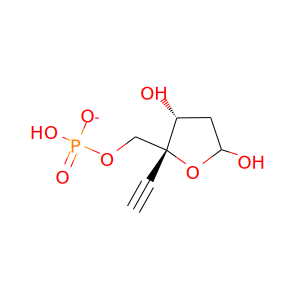



--------------------------------------------------

RANK 48 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: [O:45]=[C:46]1[O:47][C@H:48]([CH2:49][O:50][P:51](=[O:52])([O-:53])[O-:54])[C@@H:55]([OH:56])[C@H:57]([OH:58])[C@H:59]1[OH:60]>>[OH:45][CH:46]1[O:47][C@H:48]([CH2:49][O:50][P:51](=[O:52])([O-:53])[O-:54])[C@@H:55]([OH:56])[C@H:57]([OH:58])[C@H:59]1[OH:60]
Reactant SMILES: [O:45]=[C:46]1[O:47][C@H:48]([CH2:49][O:50][P:51](=[O:52])([O-:53])[O-:54])[C@@H:55]([OH:56])[C@H:57]([OH:58])[C@H:59]1[OH:60]
RHEA ID: 38217
Original Reaction SMILES from RHEA: NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=C1O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H](O)[C@H]1O.[H+]>>NC(=O)C1=CC=C[N+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)=C1.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O


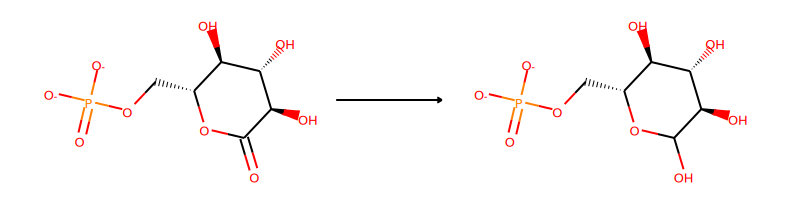

-> template: {'products': '[#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4]', 'reactants': '[#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4]', 'reaction_smarts': '([#8:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([#8:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])', 'intra_only': True, 'dimer_only': False, 'reaction_id': '38217', 'necessary_reagent': ''}
Precursor similarity 0.55, overall 0.30250000000000005, smiles C#C[C@]1(COP(=O)([O-])O)OC(=O)C[C@@H]1O


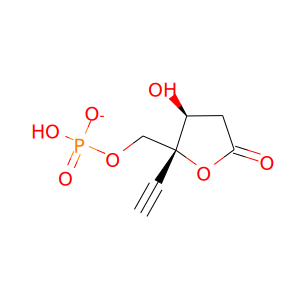



--------------------------------------------------

RANK 49 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: OC[C@H]1O[C@H]([O:37][C@H:36]2[O:35][C@H:34]([CH2:33][O:32][P:29](=[O:28])([O-:30])[O-:31])[C@@H:53]([OH:54])[C@H:51]([OH:52])[C@H:49]2[OH:50])[C@H](O)[C@@H](O)[C@@H]1O>>[O:28]=[P:29]([O-:30])([O-:31])[O:32][CH2:33][C@H:34]1[O:35][CH:36]([OH:37])[C@H:49]([OH:50])[C@@H:51]([OH:52])[C@@H:53]1[OH:54]
Reactant SMILES: OC[C@H]1O[C@H]([O:37][C@H:36]2[O:35][C@H:34]([CH2:33][O:32][P:29](=[O:28])([O-:30])[O-:31])[C@@H:53]([OH:54])[C@H:51]([OH:52])[C@H:49]2[OH:50])[C@H](O)[C@@H](O)[C@@H]1O
RHEA ID: 53882
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O.[H+]>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H]1O.O=P([O-])([O-])OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H

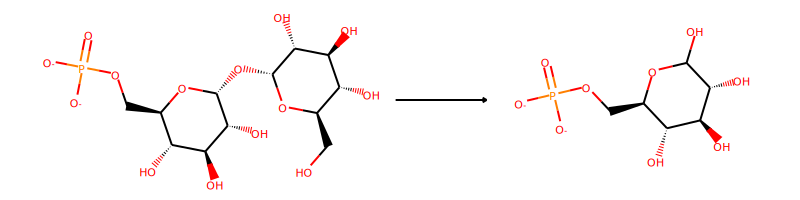

-> template: {'products': '[#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1]', 'reactants': 'O-C-[C@H]1-O-[C@H](-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])-[C@H](-O)-[C@@H](-O)-[C@@H]-1-O', 'reaction_smarts': '([#8:3]-[CH;D3;+0:2](-[C:4])-[OH;D1;+0:1])>>(O-C-[C@H]1-O-[C@H](-[O;H0;D2;+0:1]-[C@@H;D3;+0:2](-[#8:3])-[C:4])-[C@H](-O)-[C@@H](-O)-[C@@H]-1-O)', 'intra_only': True, 'dimer_only': False, 'reaction_id': '53882', 'necessary_reagent': ''}
Precursor similarity 0.7428571428571429, overall 0.40857142857142864, smiles C#C[C@]1(COP(=O)([O-])O)O[C@H](O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)C[C@@H]1O


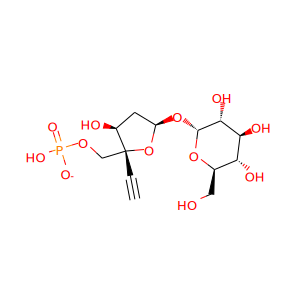



--------------------------------------------------

RANK 50 PRECEDENT
PRODUCT MATCH SCORE: 0.55
Reaction SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[O:32]=[C:33]1[CH2:34][C@H:35]([CH2:36][OH:37])[C@@H:38]([OH:39])[C@H:40]([OH:41])[C@H:42]1[OH:43]>>[P:20](=[O:21])([O-:22])([O-:23])[O:37][CH2:36][C@H:35]1[CH2:34][C:33](=[O:32])[C@H:42]([OH:43])[C@@H:40]([OH:41])[C@@H:38]1[OH:39]
Reactant SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])O[P:20](=[O:21])([O-:22])[O:23]P(=O)([O-])[O-])[C@@H](O)[C@H]1O.[O:32]=[C:33]1[CH2:34][C@H:35]([CH2:36][OH:37])[C@@H:38]([OH:39])[C@H:40]([OH:41])[C@H:42]1[OH:43]
RHEA ID: 49425
Original Reaction SMILES from RHEA: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=C1C[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O>>NC1=NC=NC2=C1N=CN2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.O=C1C[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H](O)[C@H]1O.[H+]


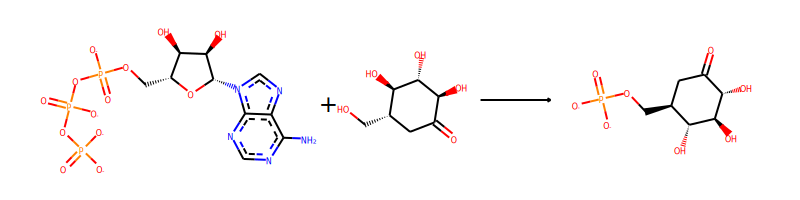

-> template: {'products': '[C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3]', 'reactants': 'N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'reaction_smarts': '([C:5]-[O;H0;D2;+0:6]-[P;H0;D4;+0:1](-[O-;H0;D1:4])(-[O;-;D1;H0:2])=[O;D1;H0:3])>>N-c1:n:c:n:c2:c:1:n:c:n:2-[C@@H]1-O-[C@H](-C-O-P(=O)(-[O-])-O-[P;H0;D4;+0:1](-[O;-;D1;H0:2])(=[O;D1;H0:3])-[O;H0;D2;+0:4]-P(=O)(-[O-])-[O-])-[C@@H](-O)-[C@H]-1-O.[C:5]-[OH;D1;+0:6]', 'intra_only': False, 'dimer_only': False, 'reaction_id': '49425', 'necessary_reagent': ''}
No precursors could be generated!


(7,
 ['OC1C[C@H](O)[C@](COP([O-])(O)=O)(C#C)O1'],
 [[1,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)C[C@@H]1O.O',
   0.5339375836852405],
  [2,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]cnc32)C[C@@H]1O.O',
   0.5301051290219815],
  [3,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(N)ncnc32)C[C@@H]1O.O',
   0.5301051290219815],
  [4,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cc(C)c(=O)[nH]c2=O)C[C@@H]1O.O',
   0.5193967998158167],
  [5,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NC/C=C(\\C)CO)ncnc32)C[C@@H]1O.O',
   0.44800000000000006],
  [6,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NCC=C(C)C)ncnc32)C[C@@H]1O.O',
   0.44377358490566043],
  [7, 'C#C[C@](O)(C=O)COP(=O)([O-])O.CC=O', 0.431813535064404],
  [8,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2nc(N)nc(O)c2N)C[C@@H]1O.O',
   0.414488188976378],
  [9,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2[nH]c(=O)[nH]c(=O)c2N)C[C@@H]1O.O',
   0.414488188976378],
  [10,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H]([n+]2cccc(C(N)=O)c2)C[C@

In [40]:
do_one (2, draw = True)

In [41]:
do_one (2, debug = True)

Desired Product:
OC1C[C@H](O)[C@](COP([O-])(O)=O)(C#C)O1
True reaction:
O=C[C@@](O)(C#C)COP([O-])(O)=O.O=CC>>OC1C[C@H](O)[C@](COP([O-])(O)=O)(C#C)O1
prec_goal: C#C[C@](O)(C=O)COP(=O)([O-])O.CC=O

Reaction precedent 1, prod similarity 0.6575342465753424
-> rxn_smiles Nc1nc2c(ncn2[C@H:9]2[CH2:10][C@H:11]([OH:12])[C@@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[O:20]2)c(=O)[nH]1.[OH2:24]>>[CH:9]1([OH:24])[CH2:10][C@H:11]([OH:12])[C@@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O-:19])[O:20]1
-> RHEA ID 57817
-> Original Reaction From RHEA: NC1=NC2=C(N=CN2[C@H]2C[C@H](O)[C@@H](COP(=O)([O-])[O-])O2)C(=O)N1.[H]O[H]>>NC1=NC2=C(N=CN2)C(=O)N1.O=P([O-])([O-])OC[C@H]1OC(O)C[C@@H]1O 
-> template: ([#8:2]-[CH;D3;+0:1](-[C:3])-[OH;D1;+0:4])>>N-c1:[nH]:c(=O):c2:n:c:n(-[C@H;D3;+0:1](-[#8:2])-[C:3]):c:2:n:1.[OH2;D0;+0:4]
-> jx: 77
prec sim 0.8120300751879699, overall 0.5339375836852405, smiles C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)C[C@@H]1O.O

Reaction precedent 2, prod simila

(7,
 ['OC1C[C@H](O)[C@](COP([O-])(O)=O)(C#C)O1'],
 [[1,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)C[C@@H]1O.O',
   0.5339375836852405],
  [2,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(=O)[nH]cnc32)C[C@@H]1O.O',
   0.5301051290219815],
  [3,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(N)ncnc32)C[C@@H]1O.O',
   0.5301051290219815],
  [4,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cc(C)c(=O)[nH]c2=O)C[C@@H]1O.O',
   0.5193967998158167],
  [5,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NC/C=C(\\C)CO)ncnc32)C[C@@H]1O.O',
   0.44800000000000006],
  [6,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](n2cnc3c(NCC=C(C)C)ncnc32)C[C@@H]1O.O',
   0.44377358490566043],
  [7, 'C#C[C@](O)(C=O)COP(=O)([O-])O.CC=O', 0.431813535064404],
  [8,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2nc(N)nc(O)c2N)C[C@@H]1O.O',
   0.414488188976378],
  [9,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H](Nc2[nH]c(=O)[nH]c(=O)c2N)C[C@@H]1O.O',
   0.414488188976378],
  [10,
   'C#C[C@]1(COP(=O)([O-])O)O[C@@H]([n+]2cccc(C(N)=O)c2)C[C@

## Step 4: Phosphate transferase

In [49]:
found_rank = do_one (3)
return_statement = re_ranker (found_rank)
return_statement

(2,
 [[11,
   'C#C[C@@](O)(COP(=O)([O-])[O-])C(=O)[O-]',
   0.5953775038520802,
   1.4474996307090726,
   0.75790214868131],
  [1,
   'C#C[C@](O)(C=O)CO.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O',
   0.7142469470827679,
   1.9796260861160069,
   0.22577569327437574],
  [8,
   'C#C[C@@](O)(COP(=O)([O-])[O-])[C@H](O)C(C)=O',
   0.6197628458498025,
   2.0780630766516284,
   0.12733870273875425],
  [10,
   'C#C[C@@](O)(COP(=O)([O-])[O-])[C@@H](O)[C@H](O)C(=O)COP(=O)([O-])[O-]',
   0.6,
   2.1165888282828087,
   0.08881295110757392],
  [5,
   'C#C[C@@](O)(COP(=O)([O-])[O-])[C@@H](O)CC(=O)C(=O)[O-]',
   0.6468449197860963,
   2.1262678895590827,
   0.07913388983129988],
  [6,
   'C#C[C@@](O)(COP(=O)([O-])[O-])C(=O)OP(=O)([O-])[O-]',
   0.6379746835443039,
   2.225346278281322,
   -0.01994449889093941],
  [4,
   'C#C[C@@](O)(COP(=O)([O-])[O-])[C@H](O)CC(=O)C(=O)[O-]',
   0.6468449197860963,
   2.3346460423147466,
   -0.12924426292436397],
  [9,
   

## Step 5: Oxidoreductase

In [50]:
found_rank = do_one (4)
return_statement = re_ranker (found_rank)
return_statement

(3,
 [[7,
   'C#C[C@@](O)(CO)C(=O)[O-]',
   0.419047619047619,
   1.1786712063353937,
   0.8009548797806132],
  [10,
   'C#C[C@@](O)(CO)CS(=O)(=O)[O-].O=O',
   0.3972413793103448,
   1.456359283174589,
   0.5232668029414178],
  [8,
   'C#CC(O)(CO)CO',
   0.4108641975308642,
   1.4707682460347642,
   0.5088578400812427],
  [11,
   'C#C[C@@](O)(CO)C(=O)C(=O)[O-]',
   0.37617554858934166,
   1.549382691647964,
   0.43024339446804283],
  [1,
   'C#C[C@@](O)(CO)[C@@H](O)CC(=O)C(=O)[O-]',
   0.5028571428571429,
   2.0677126872097054,
   -0.08808660109369848],
  [2,
   'C#C[C@@](O)(CO)[C@H](O)CC(=O)C(=O)[O-]',
   0.5028571428571429,
   2.117821114831056,
   -0.13819502871504907],
  [9,
   'C#C[C@@](O)(CO)[C@@H](O)[C@H]([NH3+])C(=O)[O-]',
   0.40868454661558107,
   2.1973959863852643,
   -0.21776990026925747],
  [4,
   'C#C[C@](O)(C=O)COP(=O)([O-])[O-]',
   0.48000000000000004,
   2.2054017793903826,
   -0.22577569327437574],
  [6,
   'C#C[C@](C=O)(CO)OP(=O)([O-])[O-]',
   0.4342857142857143,


# 1,4-Butanediol

In [51]:
#this is a file in the GitHub repository
datasub_test = pd.read_csv ('datasub_test_1_4_BDO_v1.csv')

In [52]:
# Gets Morgan Fingerprints for all products
all_fps_test = []

for smi in datasub_test['prod_smiles']:
    all_fps_test.append(getfp(smi))

#Append the fingerprints of all products
datasub_test['prod_fp'] = all_fps_test

## Step 1: Alcohol dehydrogenase

In [60]:
found_rank = do_one (0)

In [61]:
found_rank

(1,
 ['C(CCO)CO'],
 [[1, 'O=CCCCO', 0.6848989298454221],
  [2, 'CCCCO.O=O', 0.5960591133004925],
  [3, 'O=C([O-])c1ccc(C(=O)OCCCCO)cc1', 0.5672727272727273],
  [4, 'O=C([O-])c1ccc(C(=O)OCCCCO)o1', 0.5619512195121952],
  [5, 'CC(=O)OCCCCO', 0.42004118050789296],
  [6, 'O=P([O-])([O-])OCCCCO', 0.39682539682539686]],
 'O=CCCCO')

## Step 2: 4-Hydroxybutyryl-CoA reductase

In [62]:
found_rank = do_one (1)
found_rank

(1,
 ['O=CCCCO'],
 [[1,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO',
   0.7402457940579883],
  [2, 'OCCCCO', 0.6848989298454221],
  [3, 'OCCC(O)CO', 0.6520376175548589],
  [4, 'O=O.O=S(=O)([O-])CCCCO', 0.6502463054187192],
  [5, 'O=C([O-])C(=O)CCCO', 0.6351242983159583],
  [6, 'O=C([O-])CCC(=O)C(=O)[O-].[NH3+]CCCCO', 0.6036585365853658],
  [7, 'CCCC=O.O=O', 0.5960591133004925],
  [8, 'COc1ccc(C(O)C(CCCO)Oc2ccccc2OC)cc1OC', 0.5942857142857143],
  [9, 'COc1cc(C(O)C(CCCO)Oc2ccccc2OC)ccc1O', 0.5922388059701492],
  [10, 'Nc1nc2c(c(=O)[nH]1)N=C([C@H](O)[C@H](O)CCCO)CN2', 0.5784615384615385],
  [11, 'O=CCCC=O', 0.5755053507728893],
  [12, 'O.[NH3+]CCC[NH2+]CCCCO', 0.5689655172413793],
  [13, 'CC(=O)C(=O)[O-].[NH3+]CCCCO', 0.5689655172413793],
  [14, 'O=C([O-])C(=O)C[C@@H](O)CCCO', 0.5257142857142857],
  [15, 'C[N+](C)(C)CCCCO.O=O', 0.5008695652173913],
  [16, 'CCC(=O)C(O)CCCO', 0.5008695652173913],
  

## Step 3: 4-Hydroxybutyryl-CoA transferase

In [63]:
found_rank = do_one (2)
found_rank

(3,
 ['CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO'],
 [[1,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.O=C([O-])CCCO',
   1.0],
  [2,
   'C/C=C/C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-].O',
   1.0],
  [3,
   'CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-].O=C([O-])CCCO',
   0.9740185195213084],
  [4,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.CCCCCCCC/C=C\\CCCCCCCC(=O)O[C@@H](CO)COC(=O)CCCO',
   0.9599306352812722],
  [5,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.C[N+](C)(C)C[C@@H](CC(=O)

## Step 4: 4-Hydroxybutyrate dehydrogenase

In [64]:
found_rank = do_one (3)
found_rank

(1,
 ['O=C([O-])CCCO'],
 [[1, 'O=CCCC(=O)[O-]', 1.0],
  [2,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO.O=P([O-])([O-])OP(=O)([O-])O',
   1.0],
  [3,
   'CC(=O)[O-].CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO',
   0.8633852749608376],
  [4,
   'CC(=O)CC(=O)[O-].CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO',
   0.7708040153860587],
  [5,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCCO.O',
   0.7689263771737997],
  [6,
   'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCO.O',
   0.7622269203664552],
  [7,
   'CCCCCCCCCCCCCCCCOC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCO.O',
   0.7617406290392073],
  [8,
   'CC(C)(COP(=O)(

## Step 5: 2-Oxoglutarate decarboxylase

In [65]:
found_rank = do_one (4)
found_rank

(6,
 ['O=CCCC(=O)[O-]'],
 [[1, 'O=CC(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [2, 'O=C([O-])CCC(O)CC(=O)C(=O)[O-]', 1.0],
  [3, 'O=C([O-])CCC(=O)[O-]', 1.0],
  [4, 'O=C([O-])CCC(=O)C(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [5, 'C[N+](C)(C)CCCC(=O)[O-].O=O', 1.0],
  [6, 'O=C([O-])CCC(=O)C(=O)[O-]', 1.0],
  [7,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)[O-]',
   1.0],
  [8, 'O=C([O-])CCCO', 1.0],
  [9, 'O.[NH3+]CCCC(=O)[O-]', 1.0],
  [10, 'O=C([O-])CCC(=O)c1ccc(O)nc1.O=O', 1.0],
  [11, 'CC(=O)C(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [12, 'C[NH2+]CCCC(=O)[O-].O', 1.0],
  [13, 'CN(C=O)/C=C(\\CC(=O)[O-])C(=O)[O-].O', 1.0],
  [14, 'CC(=O)N/C=C(/CC(=O)[O-])C(=O)[O-].O', 1.0],
  [15,
   'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCC=O.O',
   0.8599605522682446],
  [16,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O

## Step 6: CoA-dependent succinate semialdehyde dehydrogenase

In [66]:
found_rank = do_one (5)
found_rank

(7,
 ['O=CCCC(=O)[O-]'],
 [[1, 'O=CC(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [2, 'O=C([O-])CCC(O)CC(=O)C(=O)[O-]', 1.0],
  [3, 'O=C([O-])CCC(=O)[O-]', 1.0],
  [4, 'O=C([O-])CCC(=O)C(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [5, 'C[N+](C)(C)CCCC(=O)[O-].O=O', 1.0],
  [6, 'O=C([O-])CCC(=O)C(=O)[O-]', 1.0],
  [7,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)[O-]',
   1.0],
  [8, 'O=C([O-])CCCO', 1.0],
  [9, 'O.[NH3+]CCCC(=O)[O-]', 1.0],
  [10, 'O=C([O-])CCC(=O)c1ccc(O)nc1.O=O', 1.0],
  [11, 'CC(=O)C(=O)[O-].[NH3+]CCCC(=O)[O-]', 1.0],
  [12, 'C[NH2+]CCCC(=O)[O-].O', 1.0],
  [13, 'CN(C=O)/C=C(\\CC(=O)[O-])C(=O)[O-].O', 1.0],
  [14, 'CC(=O)N/C=C(/CC(=O)[O-])C(=O)[O-].O', 1.0],
  [15,
   'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCC=O.O',
   0.8599605522682446],
  [16,
   'CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O